In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import scipy.sparse
import statsmodels.api as sm

In [2]:
pd.set_option('display.max_columns', None)

# 1. INEGI; TR_PERSONAS 

In [3]:
### Download data from INEGI 2015: https://www.inegi.org.mx/programas/intercensal/2015/#Microdatos
# VIVIENDA and PERSONA files required for all 32 states in México

os.chdir("C:\\Users\\juanm\\Documents\\Python\\cc migration model\\INEGI 2015\\TR_PERSONA")
extension = 'csv'
filenames = [i for i in glob.glob('*.{}'.format(extension))]

# create a list with selected variables:
var_per = ["ID_VIV", "INGTRMEN","MUN", "MUN_RES10", "ENT", "ENT_PAIS_RES10", "ALFABET", "EDAD", "SEXO", "CONACT", 
           "NIVACAD", "PARENT", "SERSALUD", "SITUA_CONYUGAL"]

dataframes = []
for filename in filenames:
    dataframes.append(pd.read_csv(filename, sep = ",", encoding= "cp1252", usecols= var_per))

## 1.1 TR_PERSONAS - PREPROCESSING 1

### 1.1.1 SPECIAL VARIABLES

In [4]:
# Adjust variable EDAD into ranges:
for df in dataframes:
    df["EDAD"] = pd.cut(x= df["EDAD"], bins=[0, 5, 14, 29, 59, 110], labels=["0-5", "6-14","15-29", "30-59", "60+"])
    df["EDAD"] = df["EDAD"].astype("str") 

In [5]:
# Calculate a first dependent variable: migrant; from the 4 mun and to any other mun by 2015

# 1) vars MUN and MUN_RES10 are different and
# 2) MUN_RES10 is in the list of the 4 municipalities
# 3) ENT_PAIS_RES10 was Chiapas (7)

cuatro_mun = [19, 41, 52, 99] 
for df in dataframes:
    df["migrante"] = 0
    df.loc[(df["MUN"] != df["MUN_RES10"]) &
           (df["MUN_RES10"].isin(cuatro_mun)) &
           (df["ENT_PAIS_RES10"] == 7),
           "migrante"] = 1 

In [6]:
# Calculate a second dependent variable: migrant_2; from the 4 mun but necesarily outside Chiapas by 2015

# 1) vars MUN and MUN_RES10 are different and
# 2) MUN_RES10 is in the list of the 4 municipalities
# 3) ENT_PAIS_RES10 was Chiapas (7)
# 4) ENT is different than Chiapas (7)
cuatro_mun = [19, 41, 52, 99] 
for df in dataframes:
    df["migrante_2"] = 0
    df.loc[(df["MUN"] != df["MUN_RES10"]) &
           (df["MUN_RES10"].isin(cuatro_mun)) &
           (df["ENT_PAIS_RES10"] == 7) &
           (df["ENT"] != 7), 
           "migrante_2"] = 1 

In [7]:
# Calculate a third dependent variable: migrant_3; from Chiapas to any other outside Chiapas

# 1) vars MUN and MUN_RES10 are different and
# 2) EST is different than 7 (Chiapas), meaning people migrated outside the state
for df in dataframes:
    df["migrante_3"] = 0
    df.loc[(df["MUN"] != df["MUN_RES10"]) & 
           (df["MUN_RES10"] != 999) &
           (df["ENT_PAIS_RES10"] == 7) &
           (df["ENT"] != 7), 
           "migrante_3"] = 1 

In [8]:
# Calculate a fourth dependent variable: migrant_4; internal migrant all mexico

# 1) vars MUN and MUN_RES10 are different and
# 2) MUN_RES10 is different to Null
# 3) ENT is different to ENT_PAIS_RES10
# 4) ENT_PAIS_RES10 is a mexican state, meaning people migrated internally between states or municipalities but internaly

est = [*range(1,33,1)]
for df in dataframes:
    df["migrante_4"] = 0
    df.loc[(df["MUN"] != df["MUN_RES10"]) &
           (df["MUN_RES10"] != 999) &
           (df["ENT"] != df["ENT_PAIS_RES10"]) &
           (df["ENT_PAIS_RES10"].isin(est)), 
           "migrante_4"] = 1 

In [9]:
# Merge all df´s from the list dataframes:
personas = pd.concat(dataframes, ignore_index=True)

### 1.1.2 MISSING DATA

In [10]:
personas['INGTRMEN'] = personas['INGTRMEN'].replace([999999], "NaN")

In [11]:
personas["INGTRMEN"] = personas["INGTRMEN"].astype(float)

In [12]:
personas.head()

ID_VIV  ENT  MUN  SEXO   EDAD  PARENT  SERSALUD  NIVACAD  ALFABET  \
0  10010000001    1    1     3  30-59       2         5      2.0      5.0   
1  10010000001    1    1     3   6-14       3         5      2.0      5.0   
2  10010000001    1    1     1    0-5       3         5      1.0      7.0   
3  10010000001    1    1     1  30-59       1         5      2.0      5.0   
4  10010000002    1    1     1    0-5       3         1      0.0      9.0   

   MUN_RES10  ENT_PAIS_RES10  SITUA_CONYUGAL  CONACT  INGTRMEN  migrante  \
0        1.0             1.0             1.0    33.0       NaN         0   
1        1.0             1.0             6.0    31.0       NaN         0   
2        1.0             1.0             NaN     NaN       NaN         0   
3        1.0             1.0             1.0    10.0    3857.0         0   
4        1.0             1.0             NaN     NaN       NaN         0   

   migrante_2  migrante_3  migrante_4  
0           0           0           0  
1           0           0           0  
2           0           0           0  
3           0           0           0  
4           0           0           0

### 1.1.4 FEATURE ENGINEERING

#### 1.1.4.1 Encoding variables

In [13]:
# for numeric variables:
para_dummies = ["EDAD", "PARENT", "SITUA_CONYUGAL", "SERSALUD", 'NIVACAD', 'ALFABET', 'CONACT']

In [14]:
for d in para_dummies:
    personas = pd.concat([personas, pd.get_dummies(personas[d]).rename(columns=lambda x: d+'_' + str(x))], axis = 1)
    personas = personas.drop([d], axis = 1)

#### 1.1.4.2 Drop unnecesary variables

In [15]:
personas = personas.drop(["PARENT_2", "PARENT_3", "PARENT_4", "PARENT_5", "PARENT_6", "PARENT_7", "PARENT_8", "PARENT_9", "PARENT_99",
                          "SITUA_CONYUGAL_2.0", "SITUA_CONYUGAL_3.0", "SITUA_CONYUGAL_4.0", "SITUA_CONYUGAL_6.0", "SITUA_CONYUGAL_9.0",
                          "SERSALUD_99",
                          "NIVACAD_12.0", "NIVACAD_13.0", "NIVACAD_14.0", "NIVACAD_99.0",
                          "ALFABET_9.0", 
                          "CONACT_99.0"], axis = 1)
personas.head()

ID_VIV  ENT  MUN  SEXO  MUN_RES10  ENT_PAIS_RES10  INGTRMEN  migrante  \
0  10010000001    1    1     3        1.0             1.0       NaN         0   
1  10010000001    1    1     3        1.0             1.0       NaN         0   
2  10010000001    1    1     1        1.0             1.0       NaN         0   
3  10010000001    1    1     1        1.0             1.0    3857.0         0   
4  10010000002    1    1     1        1.0             1.0       NaN         0   

   migrante_2  migrante_3  migrante_4  EDAD_0-5  EDAD_15-29  EDAD_30-59  \
0           0           0           0         0           0           1   
1           0           0           0         0           0           0   
2           0           0           0         1           0           0   
3           0           0           0         0           0           1   
4           0           0           0         1           0           0   

   EDAD_6-14  EDAD_60+  EDAD_nan  PARENT_1  SITUA_CONYUGAL_1.0  \
0          0         0         0         0                   1   
1          1         0         0         0                   0   
2          0         0         0         0                   0   
3          0         0         0         1                   1   
4          0         0         0         0                   0   

   SITUA_CONYUGAL_5.0  SERSALUD_1  SERSALUD_2  SERSALUD_3  SERSALUD_4  \
0                   0           0           0           0           0   
1                   0           0           0           0           0   
2                   0           0           0           0           0   
3                   0           0           0           0           0   
4                   0           1           0           0           0   

   SERSALUD_5  SERSALUD_6  SERSALUD_7  SERSALUD_8  SERSALUD_9  NIVACAD_0.0  \
0           1           0           0           0           0            0   
1           1           0           0           0           0            0   
2           1           0           0           0           0            0   
3           1           0           0           0           0            0   
4           0           0           0           0           0            1   

   NIVACAD_1.0  NIVACAD_2.0  NIVACAD_3.0  NIVACAD_4.0  NIVACAD_5.0  \
0            0            1            0            0            0   
1            0            1            0            0            0   
2            1            0            0            0            0   
3            0            1            0            0            0   
4            0            0            0            0            0   

   NIVACAD_6.0  NIVACAD_7.0  NIVACAD_8.0  NIVACAD_9.0  NIVACAD_10.0  \
0            0            0            0            0             0   
1            0            0            0            0             0   
2            0            0            0            0             0   
3            0            0            0            0             0   
4            0            0            0            0             0   

   NIVACAD_11.0  ALFABET_5.0  ALFABET_7.0  CONACT_10.0  CONACT_11.0  \
0             0            1            0            0            0   
1             0            1            0            0            0   
2             0            0            1            0            0   
3             0            1            0            1            0   
4             0            0            0            0            0   

   CONACT_12.0  CONACT_13.0  CONACT_14.0  CONACT_15.0  CONACT_16.0  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   CONACT_20.0  CONACT_31.0  CONACT_32.0  CONACT_33.0  CONACT_34.0  \

In [16]:
personas["migrante"].value_counts()

0    22690134
1        2131
Name: migrante, dtype: int64

In [17]:
personas["migrante_2"].value_counts()

0    22691703
1         562
Name: migrante_2, dtype: int64

In [18]:
personas["migrante_3"].value_counts()

0    22683731
1        8534
Name: migrante_3, dtype: int64

In [19]:
personas["migrante_4"].value_counts()

0    22343963
1      348302
Name: migrante_4, dtype: int64

In [20]:
os.chdir("C:\\Users\\juanm\\Documents\\Python\\cc migration model\\CC&MIGRATION")
personas.to_csv("PERSONAS.csv", index = False)

In [21]:
del personas

## 1.2 TR_PERSONAS - PREPROCESSING 2
Load PERSONAS.csv in chunks for preprocessing #2: Get dataset ready for merging with TR_VIVIENDA

In [22]:
os.chdir("C:\\Users\\juanm\\Documents\\Python\\cc migration model\\CC&MIGRATION\\TR_PERSONA_MERGE")

### 1.2.1 Social Capital

In [23]:
var_capsocial = ["PARENT_1", "SITUA_CONYUGAL_1.0", "SITUA_CONYUGAL_5.0"]

In [24]:
capsocial = pd.read_csv("C:\\Users\\juanm\\Documents\\Python\\cc migration model\\CC&MIGRATION\\PERSONAS.csv", usecols= var_capsocial)

In [25]:
capsocial["JEFE_SC"] = 0 # add a class column with 0 as default value
# find all rows that fulfills your conditions and set class to 1
capsocial.loc[(capsocial["PARENT_1"] == 1) & # if PARENT_1 is 1: Jefe de hogar 
      (capsocial["SITUA_CONYUGAL_1.0"] + capsocial["SITUA_CONYUGAL_5.0"] != 0), # si la situación conyugal del jefe de hogar es casado o union libre 
       "JEFE_SC"] = 1 # then set class to 1

In [26]:
capsocial = capsocial.drop(["SITUA_CONYUGAL_1.0", "SITUA_CONYUGAL_5.0", "PARENT_1"], axis = 1)

In [27]:
capsocial.to_csv("capsocial.csv", index = False)
del capsocial

### 1.2.2 Human Capital 

- Nivel de educación del jefe del hogar (TR_PERSONA.PARENT / NIVACAD / ALFABET)
    - PARENT == 1 copiar ALFABET
    - PARENT == 1 copiar el NIVACAD
- Número de personas en el hogar (# de niños < 5años) (TR_PERSONA.EDAD)
    - Cuando se resuma en groupby por ID_VIV.sum() el conteo estará por grupo etareo
- Número de personas en el hogar con edad productiva (TR_PERSONA.EDAD)
    - Cuando se resuma en groupby por ID_VIV.sum() el conteo estará por grupo etareo

In [28]:
var_caphumano = ["ID_VIV", "PARENT_1", 
                 "NIVACAD_0.0", "NIVACAD_1.0", "NIVACAD_2.0", "NIVACAD_3.0", 
                 "NIVACAD_4.0", "NIVACAD_5.0", "NIVACAD_6.0", "NIVACAD_7.0", 
                 "NIVACAD_8.0", "NIVACAD_9.0", "NIVACAD_10.0", "NIVACAD_11.0", 
                 "ALFABET_5.0", "ALFABET_7.0"]

In [29]:
caphumano = pd.read_csv("C:\\Users\\juanm\\Documents\\Python\\cc migration model\\CC&MIGRATION\\PERSONAS.csv", usecols= var_caphumano)

In [30]:
niveles_academicos = ["NIVACAD_0.0", "NIVACAD_1.0", "NIVACAD_2.0", "NIVACAD_3.0", 
                      "NIVACAD_4.0", "NIVACAD_5.0", "NIVACAD_6.0", "NIVACAD_7.0", 
                      "NIVACAD_8.0", "NIVACAD_9.0", "NIVACAD_10.0", "NIVACAD_11.0"]

In [31]:
for col in niveles_academicos:
    caphumano[col + "_J"] = 0
    caphumano.loc[(caphumano["PARENT_1"] == 1) &
                 (caphumano[col] == 1),
                 col + "_J"] = 1 # then set class to 1
    caphumano = caphumano.drop([col], axis = 1) # drop original column

In [32]:
niv_alfab = ["ALFABET_5.0", "ALFABET_7.0"]

In [33]:
for col in niv_alfab:
    caphumano[col + "_J"] = 0
    caphumano.loc[(caphumano["PARENT_1"] == 1) &
                 (caphumano[col] == 1),
                 col + "_J"] = 1 # then set class to 1
    caphumano = caphumano.drop([col], axis = 1) # drop original column

In [34]:
caphumano = caphumano.drop(["ID_VIV", "PARENT_1"], axis = 1)

In [35]:
caphumano.to_csv("caphumano.csv", index = False)
del caphumano

### 1.2.3 Variables SERSALUD

In [36]:
var_sersalud = ["SERSALUD_1", "SERSALUD_2", "SERSALUD_3", "SERSALUD_4", "SERSALUD_5", "SERSALUD_6", "SERSALUD_7", "SERSALUD_8", "SERSALUD_9"]

In [37]:
sersalud = pd.read_csv("C:\\Users\\juanm\\Documents\\Python\\cc migration model\\CC&MIGRATION\\PERSONAS.csv", usecols= var_sersalud)

In [38]:
sersalud["SERSALUD"] = 0 
sersalud.loc[(sersalud["SERSALUD_1"] + sersalud["SERSALUD_2"] + sersalud["SERSALUD_3"] + 
              sersalud["SERSALUD_4"] + sersalud["SERSALUD_5"] + sersalud["SERSALUD_6"] +
              sersalud["SERSALUD_7"] + sersalud["SERSALUD_8"] != 0),
              "SERSALUD"] = 1

In [39]:
sersalud = sersalud.rename(columns = {"SERSALUD_9": "SERSALUD_NO"}) 

In [40]:
sersalud = sersalud.drop(["SERSALUD_1", "SERSALUD_2", "SERSALUD_3", "SERSALUD_4", "SERSALUD_5", "SERSALUD_6", "SERSALUD_7", "SERSALUD_8"], axis = 1)

In [41]:
sersalud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22692265 entries, 0 to 22692264
Data columns (total 2 columns):
 #   Column       Dtype
---  ------       -----
 0   SERSALUD_NO  int64
 1   SERSALUD     int64
dtypes: int64(2)
memory usage: 346.3 MB


In [42]:
sersalud.to_csv("sersalud.csv", index = False)
del sersalud

### 1.2.4 Generate a singel file with variables that did not have preprocessing #2 and must be in final personas df

In [43]:
vargen = ["ID_VIV", "INGTRMEN", "migrante", "migrante_2", "migrante_3", "migrante_4", "EDAD_0-5", "EDAD_15-29", "EDAD_30-59", "EDAD_6-14","EDAD_60+",  
          "CONACT_10.0", "CONACT_13.0", "CONACT_31.0"]

In [44]:
variables = pd.read_csv("C:\\Users\\juanm\\Documents\\Python\\cc migration model\\CC&MIGRATION\\PERSONAS.csv", usecols= vargen)

In [45]:
variables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22692265 entries, 0 to 22692264
Data columns (total 14 columns):
 #   Column       Dtype  
---  ------       -----  
 0   ID_VIV       int64  
 1   INGTRMEN     float64
 2   migrante     int64  
 3   migrante_2   int64  
 4   migrante_3   int64  
 5   migrante_4   int64  
 6   EDAD_0-5     int64  
 7   EDAD_15-29   int64  
 8   EDAD_30-59   int64  
 9   EDAD_6-14    int64  
 10  EDAD_60+     int64  
 11  CONACT_10.0  int64  
 12  CONACT_13.0  int64  
 13  CONACT_31.0  int64  
dtypes: float64(1), int64(13)
memory usage: 2.4 GB


In [46]:
variables.to_csv("variables.csv", index = False)
del variables

### 1.2.5 Read all files in TR_PERSONA_MERGE and merge

In [47]:
os.chdir("C:\\Users\\juanm\\Documents\\Python\\cc migration model\\CC&MIGRATION\\TR_PERSONA_MERGE")
# Use glob to match the pattern ‘csv’
extension = 'csv'
filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [48]:
# Create the list of all DataFrames: dataframes:
dataframes = []
for filename in filenames:
    dataframes.append(pd.read_csv(filename))

In [49]:
# Unir todos los df de la lista dataframes:
personas = pd.concat(dataframes, axis = 1)

In [50]:
del dataframes

In [51]:
personas = personas.groupby("ID_VIV").sum()

### 1.2.6 Add MUN_RES10 and ENT_PAIS_RES10

In [55]:
# geovars = ["ID_VIV", "MUN_RES10", "ENT_PAIS_RES10"]
geovars = ["ID_VIV", "MUN", "ENT"]
geo = pd.read_csv("C:\\Users\\juanm\\Documents\\Python\\cc migration model\\CC&MIGRATION\\PERSONAS.csv", usecols= geovars)

In [56]:
geo = geo.groupby("ID_VIV").first()
geo = geo.reset_index()
geo.head()

ID_VIV  ENT  MUN
0  10010000001    1    1
1  10010000002    1    1
2  10010000003    1    1
3  10010000004    1    1
4  10010000005    1    1

In [57]:
geo.isnull().sum(axis = 0)

ID_VIV    0
ENT       0
MUN       0
dtype: int64

In [53]:
#geo = geo.groupby("ID_VIV").mean()
#Esto era un error, mejor el cambio a ENT y MUN número 1 en el dataframe, en teoría es del jefe de hogar

In [58]:
personas2 = pd.merge(personas, geo, how = "left", on= "ID_VIV")

In [59]:
personas2.columns

Index(['ID_VIV', 'NIVACAD_0.0_J', 'NIVACAD_1.0_J', 'NIVACAD_2.0_J',
       'NIVACAD_3.0_J', 'NIVACAD_4.0_J', 'NIVACAD_5.0_J', 'NIVACAD_6.0_J',
       'NIVACAD_7.0_J', 'NIVACAD_8.0_J', 'NIVACAD_9.0_J', 'NIVACAD_10.0_J',
       'NIVACAD_11.0_J', 'ALFABET_5.0_J', 'ALFABET_7.0_J', 'JEFE_SC',
       'SERSALUD_NO', 'SERSALUD', 'INGTRMEN', 'migrante', 'migrante_2',
       'migrante_3', 'migrante_4', 'EDAD_0-5', 'EDAD_15-29', 'EDAD_30-59',
       'EDAD_6-14', 'EDAD_60+', 'CONACT_10.0', 'CONACT_13.0', 'CONACT_31.0',
       'ENT', 'MUN'],
      dtype='object')

In [60]:
personas2 = personas2.reset_index()

In [61]:
personas2.head()

index       ID_VIV  NIVACAD_0.0_J  NIVACAD_1.0_J  NIVACAD_2.0_J  \
0      0  10010000001              0              0              1   
1      1  10010000002              0              0              0   
2      2  10010000003              0              0              0   
3      3  10010000004              0              0              0   
4      4  10010000005              0              0              0   

   NIVACAD_3.0_J  NIVACAD_4.0_J  NIVACAD_5.0_J  NIVACAD_6.0_J  NIVACAD_7.0_J  \
0              0              0              0              0              0   
1              1              0              0              0              0   
2              1              0              0              0              0   
3              0              1              0              0              0   
4              1              0              0              0              0   

   NIVACAD_8.0_J  NIVACAD_9.0_J  NIVACAD_10.0_J  NIVACAD_11.0_J  \
0              0              0               0               0   
1              0              0               0               0   
2              0              0               0               0   
3              0              0               0               0   
4              0              0               0               0   

   ALFABET_5.0_J  ALFABET_7.0_J  JEFE_SC  SERSALUD_NO  SERSALUD  INGTRMEN  \
0              1              0        1            0         4    3857.0   
1              1              0        1            0         7    6429.0   
2              1              0        1            0         2    4286.0   
3              1              0        1            0         3   10000.0   
4              1              0        1            0         3    6000.0   

   migrante  migrante_2  migrante_3  migrante_4  EDAD_0-5  EDAD_15-29  \
0         0           0           0           0         1           0   
1         0           0           0           0         2           2   
2         0           0           0           0         0           2   
3         0           0           0           0         0           1   
4         0           0           0           0         1           2   

   EDAD_30-59  EDAD_6-14  EDAD_60+  CONACT_10.0  CONACT_13.0  CONACT_31.0  \
0           2          1         0            1            0            1   
1           2          1         0            1            0            1   
2           0          0         0            1            0            0   
3           2          0         0            1            0            1   
4           0          0         0            2            0            0   

   ENT  MUN  
0    1    1  
1    1    1  
2    1    1  
3    1    1  
4    1    1

### 1.2.7 Transform dependent variables to 0 an ones

In [62]:
conditions  = [ (personas2["migrante"] == 0), ((personas2["migrante"] > 0) & (personas2["migrante"] <= 30)) ]
choices     = [0, 1]
personas2["migrante"] = np.select(conditions, choices, default= np.nan)
personas2["migrante"].value_counts()

0.0    5853169
1.0       1223
Name: migrante, dtype: int64

In [63]:
conditions  = [ (personas2["migrante_2"] == 0), ((personas2["migrante_2"] > 0) & (personas2["migrante_2"] <= 30)) ]
choices     = [0, 1]
personas2["migrante_2"] = np.select(conditions, choices, default= np.nan)
personas2["migrante_2"].value_counts()

0.0    5854094
1.0        298
Name: migrante_2, dtype: int64

In [64]:
conditions  = [ (personas2["migrante_3"] == 0), ((personas2["migrante_3"] > 0) & (personas2["migrante_3"] <= 30)) ]
choices     = [0, 1]
personas2["migrante_3"] = np.select(conditions, choices, default= np.nan)
personas2["migrante_3"].value_counts()

0.0    5849881
1.0       4511
Name: migrante_3, dtype: int64

In [65]:
conditions  = [ (personas2["migrante_4"] == 0), ((personas2["migrante_4"] > 0) & (personas2["migrante_4"] <= 30)) ]
choices     = [0, 1]
personas2["migrante_4"] = np.select(conditions, choices, default= np.nan)
personas2["migrante_4"].value_counts()

0.0    5675152
1.0     179240
Name: migrante_4, dtype: int64

### 1.1.3 STANDARIZING DATA

#### 1.1.3.1 Scaling data- MinMax Scaler

In [66]:
# MinMaxScaler; keeps the same distribution but reduces the scale with 0 at the min value and 1 at the max.
min_max_scaler = MinMaxScaler()
personas2[["INGTRMEN"]] = min_max_scaler.fit_transform(personas2[["INGTRMEN"]])

### 1.2.8 Save PERSONAS

In [67]:
os.chdir("C:\\Users\\juanm\\Documents\\Python\\cc migration model\\CC&MIGRATION")
personas2.to_csv("PERSONAS7.csv", index = False)

In [68]:
del personas, personas2

# 2. INEGI; TR_VIVIENDAS

In [66]:
os.chdir("C:\\Users\\juanm\\Documents\\Python\\cc migration model\\INEGI 2015\\TR_VIVIENDA")

extension = 'csv'
filenames = [i for i in glob.glob('*.{}'.format(extension))]

var_viv = ["ID_VIV", "FACTOR", 
           "COCINA", "COMBUSTIBLE", "ELECTRICIDAD", "ABA_AGUA_ENTU",
           "AUTOPROP", "TELEFONO", "CELULAR",
           "TENENCIA", "DEUDA", "NUMPERS",
           "INGR_PEROTROPAIS", "INGR_PERDENTPAIS", "INGR_AYUGOB", "TERRENO_AGROPE",
           "TERRENO_VIVERO", "ALIM_ADU1", "ALIM_ADU2", "ALIM_ADU3", "ING_ALIM_ADU1",
           "ING_ALIM_ADU2", "ING_ALIM_ADU3", "ALIM_MEN1", "ALIM_MEN2", "ALIM_MEN3",
           "ING_ALIM_MEN1", "ING_ALIM_MEN2", "ING_ALIM_MEN3", "JEFE_SEXO"]

dataframes = []
for filename in filenames:
    dataframes.append(pd.read_csv(filename, sep = ",", encoding= "cp1252", usecols= var_viv))

In [67]:
# Merge all df in list
viviendas = pd.concat(dataframes, ignore_index=True)
viviendas.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5854392 entries, 0 to 5854391
Data columns (total 30 columns):
 #   Column            Dtype  
---  ------            -----  
 0   ID_VIV            int64  
 1   FACTOR            int64  
 2   COCINA            float64
 3   COMBUSTIBLE       float64
 4   ELECTRICIDAD      float64
 5   ABA_AGUA_ENTU     float64
 6   AUTOPROP          float64
 7   TELEFONO          float64
 8   CELULAR           float64
 9   TENENCIA          float64
 10  DEUDA             float64
 11  NUMPERS           int64  
 12  INGR_PEROTROPAIS  int64  
 13  INGR_PERDENTPAIS  int64  
 14  INGR_AYUGOB       int64  
 15  TERRENO_AGROPE    int64  
 16  TERRENO_VIVERO    int64  
 17  ALIM_ADU1         int64  
 18  ALIM_ADU2         int64  
 19  ALIM_ADU3         int64  
 20  ING_ALIM_ADU1     int64  
 21  ING_ALIM_ADU2     int64  
 22  ING_ALIM_ADU3     int64  
 23  ALIM_MEN1         float64
 24  ALIM_MEN2         float64
 25  ALIM_MEN3         float64
 26  ING_ALIM_MEN1 

## 2.1 TR_VIVIENDAS - PREPROCESSING

#### 2.1.1 FEATURE ENGINEERING

In [68]:
# encoding numeric variables
para_dummies = ["COCINA", "COMBUSTIBLE", "ELECTRICIDAD", "ABA_AGUA_ENTU", 
                "AUTOPROP", "TELEFONO", "CELULAR", 
                "TENENCIA", "DEUDA",
                "INGR_PEROTROPAIS", "INGR_PERDENTPAIS", "INGR_AYUGOB", "TERRENO_AGROPE",
                "TERRENO_VIVERO", "ALIM_ADU1", "ALIM_ADU2", "ALIM_ADU3", "ING_ALIM_ADU1",
                "ING_ALIM_ADU2", "ING_ALIM_ADU3", "ALIM_MEN1", "ALIM_MEN2", "ALIM_MEN3",
                "ING_ALIM_MEN1", "ING_ALIM_MEN2", "ING_ALIM_MEN3", "JEFE_SEXO"]

In [69]:
for d in para_dummies:
    viviendas = pd.concat([viviendas, pd.get_dummies(viviendas[d]).rename(columns=lambda x: d+'_' + str(x))], axis = 1)
    viviendas = viviendas.drop([d], axis = 1)

In [70]:
pd.set_option('display.max_columns', None)
viviendas.head()

ID_VIV  FACTOR  NUMPERS  COCINA_1.0  COCINA_3.0  COCINA_9.0  \
0  10010000001      15        4           1           0           0   
1  10010000002      35        7           1           0           0   
2  10010000003      16        2           1           0           0   
3  10010000004      20        3           1           0           0   
4  10010000005      13        3           0           1           0   

   COMBUSTIBLE_1.0  COMBUSTIBLE_2.0  COMBUSTIBLE_3.0  COMBUSTIBLE_4.0  \
0                0                1                0                0   
1                0                1                0                0   
2                0                1                0                0   
3                0                1                0                0   
4                0                1                0                0   

   COMBUSTIBLE_5.0  COMBUSTIBLE_9.0  ELECTRICIDAD_5.0  ELECTRICIDAD_7.0  \
0                0                0                 1                 0   
1                0                0                 1                 0   
2                0                0                 1                 0   
3                0                0                 1                 0   
4                0                0                 1                 0   

   ELECTRICIDAD_9.0  ABA_AGUA_ENTU_1.0  ABA_AGUA_ENTU_2.0  ABA_AGUA_ENTU_3.0  \
0                 0                  1                  0                  0   
1                 0                  1                  0                  0   
2                 0                  1                  0                  0   
3                 0                  1                  0                  0   
4                 0                  1                  0                  0   

   ABA_AGUA_ENTU_4.0  ABA_AGUA_ENTU_5.0  ABA_AGUA_ENTU_6.0  ABA_AGUA_ENTU_9.0  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   AUTOPROP_7.0  AUTOPROP_8.0  AUTOPROP_9.0  TELEFONO_1.0  TELEFONO_2.0  \
0             0             1             0             0             1   
1             1             0             0             1             0   
2             1             0             0             0             1   
3             1             0             0             0             1   
4             1             0             0             0             1   

   TELEFONO_9.0  CELULAR_3.0  CELULAR_4.0  CELULAR_9.0  TENENCIA_1.0  \
0             0            1            0            0             0   
1             0            1            0            0             1   
2             0            1            0            0             0   
3             0            1            0            0             1   
4             0            1            0            0             1   

   TENENCIA_2.0  TENENCIA_3.0  TENENCIA_4.0  TENENCIA_9.0  DEUDA_1.0  \
0             0             1             0             0          0   
1             0             0             0             0          1   
2             1             0             0             0          0   
3             0             0             0             0          0   
4             0             0             0             0          0   

   DEUDA_2.0  DEUDA_3.0  DEUDA_8.0  DEUDA_9.0  INGR_PEROTROPAIS_1  \
0          0          0          0          0                   0   
1          0          0          0          0                   0   
2          0          0          0          0                   0   
3          1          0          0          0                   0   
4          1          0          0          0                

In [71]:
viviendas = viviendas.drop(["COCINA_3.0", "COCINA_9.0", "COMBUSTIBLE_5.0", "COMBUSTIBLE_9.0", "ELECTRICIDAD_7.0", "ELECTRICIDAD_9.0",
                            "ABA_AGUA_ENTU_6.0", "ABA_AGUA_ENTU_9.0",
                            "AUTOPROP_8.0", "AUTOPROP_9.0","TELEFONO_2.0", "TELEFONO_9.0","CELULAR_4.0", "CELULAR_9.0",
                            "TENENCIA_3.0", "TENENCIA_4.0", "TENENCIA_9.0",
                            "DEUDA_3.0","DEUDA_8.0", "DEUDA_9.0",
                            "INGR_PEROTROPAIS_2", "INGR_PEROTROPAIS_9", "INGR_PERDENTPAIS_4", "INGR_PERDENTPAIS_9","INGR_AYUGOB_6", "INGR_AYUGOB_9", 
                            "TERRENO_AGROPE_2", "TERRENO_AGROPE_8", "TERRENO_AGROPE_9","TERRENO_VIVERO_4", "TERRENO_VIVERO_8", "TERRENO_VIVERO_9",
                            "ALIM_ADU1_2", "ALIM_ADU1_9", "ALIM_ADU2_4", "ALIM_ADU2_9", "ALIM_ADU3_6", "ALIM_ADU3_9",
                            "ING_ALIM_ADU1_2", "ING_ALIM_ADU1_9", "ING_ALIM_ADU2_4", "ING_ALIM_ADU2_9", "ING_ALIM_ADU3_6", "ING_ALIM_ADU3_9",
                            "ALIM_MEN1_2.0", "ALIM_MEN1_9.0", "ALIM_MEN2_4.0", "ALIM_MEN2_9.0", "ALIM_MEN3_6.0", "ALIM_MEN3_9.0",
                            "ING_ALIM_MEN1_2.0", "ING_ALIM_MEN1_9.0", "ING_ALIM_MEN2_4.0", "ING_ALIM_MEN2_9.0", "ING_ALIM_MEN3_6.0", "ING_ALIM_MEN3_9.0",
                            "JEFE_SEXO_1"], axis = 1)

### 2.1.2 FOOD SECURITY

La escala EMSA (CONEVAL, INEGI) tiene 12 variables para medir INSAN, 

Para hogares de solo adultos:
- si la suma de variables de insan = 0, INSAN = seguridad = 0
- si la suma de variables de insan = (1-2), INSAN = inseguridad alimentaria leve = 1
- si la suma de variables de insan = (3-4 o más), INSAN = inseguridad alimentaria moderada = 2

Para hogares con adultos y menores:
- si la suma de variables de insan = 0, INSAN = seguridad = 0
- si la suma de variables de insan = (1-3), INSAN = inseguridad alimentaria leve = 1
- si la suma de variables de insan = (4-7), INSAN = inseguridad alimentaria moderada = 2
- si la suma de variables de insan = (8-12), INSAN = inseguridad alimentaria severa = 3

In [72]:
varalim = viviendas[["ALIM_ADU1_1", "ALIM_ADU2_3", "ALIM_ADU3_5", "ING_ALIM_ADU1_1", "ING_ALIM_ADU2_3", "ING_ALIM_ADU3_5", 
"ALIM_MEN1_1.0", "ALIM_MEN2_3.0", "ALIM_MEN3_5.0", "ING_ALIM_MEN1_1.0", "ING_ALIM_MEN2_3.0", "ING_ALIM_MEN3_5.0"]]

In [73]:
varalim["ALIM_ADUL"] = varalim[["ALIM_ADU1_1", "ALIM_ADU2_3", "ALIM_ADU3_5", "ING_ALIM_ADU1_1", "ING_ALIM_ADU2_3", "ING_ALIM_ADU3_5"]].sum(axis = 1)

<ipython-input-73-819c387e8b8c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  varalim["ALIM_ADUL"] = varalim[["ALIM_ADU1_1", "ALIM_ADU2_3", "ALIM_ADU3_5", "ING_ALIM_ADU1_1", "ING_ALIM_ADU2_3", "ING_ALIM_ADU3_5"]].sum(axis = 1)


In [74]:
varalim["ALIM_MEN"] = varalim[["ALIM_MEN1_1.0", "ALIM_MEN2_3.0", "ALIM_MEN3_5.0", "ING_ALIM_MEN1_1.0", "ING_ALIM_MEN2_3.0", "ING_ALIM_MEN3_5.0"]].sum(axis = 1)

<ipython-input-74-c66d069c3bf0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  varalim["ALIM_MEN"] = varalim[["ALIM_MEN1_1.0", "ALIM_MEN2_3.0", "ALIM_MEN3_5.0", "ING_ALIM_MEN1_1.0", "ING_ALIM_MEN2_3.0", "ING_ALIM_MEN3_5.0"]].sum(axis = 1)


In [75]:
varalim

ALIM_ADU1_1  ALIM_ADU2_3  ALIM_ADU3_5  ING_ALIM_ADU1_1  \
0                  0            0            0                0   
1                  0            0            0                0   
2                  0            0            0                0   
3                  0            0            0                0   
4                  1            1            1                1   
...              ...          ...          ...              ...   
5854387            0            0            1                0   
5854388            0            1            1                0   
5854389            0            0            0                0   
5854390            0            0            1                0   
5854391            0            0            0                0   

         ING_ALIM_ADU2_3  ING_ALIM_ADU3_5  ALIM_MEN1_1.0  ALIM_MEN2_3.0  \
0                      0                0              0              0   
1                      0                0              0              0   
2                      0                0              0              0   
3                      0                0              0              0   
4                      1                1              1              1   
...                  ...              ...            ...            ...   
5854387                0                0              0              0   
5854388                0                0              0              0   
5854389                0                0              0              0   
5854390                0                0              0              0   
5854391                0                0              0              0   

         ALIM_MEN3_5.0  ING_ALIM_MEN1_1.0  ING_ALIM_MEN2_3.0  \
0                    0                  0                  0   
1                    0                  0                  0   
2                    0                  0                  0   
3                    0                  0                  0   
4                    1                  0                  0   
...                ...                ...                ...   
5854387              0                  0                  0   
5854388              0                  0                  0   
5854389              0                  0                  0   
5854390              0                  0                  0   
5854391              0                  0                  0   

         ING_ALIM_MEN3_5.0  ALIM_ADUL  ALIM_MEN  
0                        0          0         0  
1                        0          0         0  
2                        0          0         0  
3                        0          0         0  
4                        0          6         3  
...                    ...        ...       ...  
5854387                  0          1         0  
5854388                  0          2         0  
5854389                  0          0         0  
5854390                  0          1         0  
5854391                  0          0         0  

[5854392 rows x 14 columns]

In [76]:
varalim = varalim.drop(["ALIM_ADU1_1", "ALIM_ADU2_3", "ALIM_ADU3_5", "ING_ALIM_ADU1_1", "ING_ALIM_ADU2_3", "ING_ALIM_ADU3_5", 
"ALIM_MEN1_1.0", "ALIM_MEN2_3.0", "ALIM_MEN3_5.0", "ING_ALIM_MEN1_1.0", "ING_ALIM_MEN2_3.0", "ING_ALIM_MEN3_5.0"], axis = 1)

In [77]:
varalim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5854392 entries, 0 to 5854391
Data columns (total 2 columns):
 #   Column     Dtype
---  ------     -----
 0   ALIM_ADUL  int64
 1   ALIM_MEN   int64
dtypes: int64(2)
memory usage: 89.3 MB


In [78]:
varalim["c"] = varalim[["ALIM_ADUL", "ALIM_MEN"]].sum(axis = 1)

In [79]:
conditions  = [ (varalim["c"] == 0),
               ((varalim["c"] > 0) & (varalim["c"] <= 3) & (varalim["ALIM_MEN"] > 0)),
               ((varalim["ALIM_ADUL"] > 0) & (varalim["ALIM_ADUL"] <= 2) & (varalim["ALIM_MEN"] == 0)),
               ((varalim["c"] > 3) & (varalim["c"] <= 7) & (varalim["ALIM_MEN"] > 0)),
               ((varalim["ALIM_ADUL"] > 2) & (varalim["ALIM_ADUL"] <= 4) & (varalim["ALIM_MEN"] == 0)),
               ((varalim["c"] > 7) & (varalim["c"] <= 12) & (varalim["ALIM_MEN"] > 0)),
               ((varalim["ALIM_ADUL"] > 4) & (varalim["ALIM_ADUL"] <= 6) & (varalim["ALIM_MEN"] == 0)) ]
                
choices     = [0, 1, 1, 2, 2, 3, 3]

varalim["INSAN"] = np.select(conditions, choices, default= np.nan)

In [80]:
varalim["INSAN"].value_counts()

0.0    3618062
1.0    1091465
3.0     599997
2.0     544868
Name: INSAN, dtype: int64

In [81]:
varalim = varalim.drop(["ALIM_ADUL", "ALIM_MEN", "c"], axis = 1)

In [82]:
viviendas = viviendas.drop(['ALIM_ADU1_1', 'ALIM_ADU2_3', 'ALIM_ADU3_5', 'ING_ALIM_ADU1_1', 'ING_ALIM_ADU2_3',
                            'ING_ALIM_ADU3_5', 'ALIM_MEN1_1.0', 'ALIM_MEN2_3.0', 'ALIM_MEN3_5.0', 'ING_ALIM_MEN1_1.0', 
                            'ING_ALIM_MEN2_3.0', 'ING_ALIM_MEN3_5.0'], axis = 1)

In [83]:
viviendas = pd.concat([viviendas, varalim], axis = 1)

In [84]:
viviendas.columns

Index(['ID_VIV', 'FACTOR', 'NUMPERS', 'COCINA_1.0', 'COMBUSTIBLE_1.0',
       'COMBUSTIBLE_2.0', 'COMBUSTIBLE_3.0', 'COMBUSTIBLE_4.0',
       'ELECTRICIDAD_5.0', 'ABA_AGUA_ENTU_1.0', 'ABA_AGUA_ENTU_2.0',
       'ABA_AGUA_ENTU_3.0', 'ABA_AGUA_ENTU_4.0', 'ABA_AGUA_ENTU_5.0',
       'AUTOPROP_7.0', 'TELEFONO_1.0', 'CELULAR_3.0', 'TENENCIA_1.0',
       'TENENCIA_2.0', 'DEUDA_1.0', 'DEUDA_2.0', 'INGR_PEROTROPAIS_1',
       'INGR_PERDENTPAIS_3', 'INGR_AYUGOB_5', 'TERRENO_AGROPE_1',
       'TERRENO_VIVERO_3', 'JEFE_SEXO_3', 'INSAN'],
      dtype='object')

In [85]:
viviendas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5854392 entries, 0 to 5854391
Data columns (total 28 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ID_VIV              int64  
 1   FACTOR              int64  
 2   NUMPERS             int64  
 3   COCINA_1.0          uint8  
 4   COMBUSTIBLE_1.0     uint8  
 5   COMBUSTIBLE_2.0     uint8  
 6   COMBUSTIBLE_3.0     uint8  
 7   COMBUSTIBLE_4.0     uint8  
 8   ELECTRICIDAD_5.0    uint8  
 9   ABA_AGUA_ENTU_1.0   uint8  
 10  ABA_AGUA_ENTU_2.0   uint8  
 11  ABA_AGUA_ENTU_3.0   uint8  
 12  ABA_AGUA_ENTU_4.0   uint8  
 13  ABA_AGUA_ENTU_5.0   uint8  
 14  AUTOPROP_7.0        uint8  
 15  TELEFONO_1.0        uint8  
 16  CELULAR_3.0         uint8  
 17  TENENCIA_1.0        uint8  
 18  TENENCIA_2.0        uint8  
 19  DEUDA_1.0           uint8  
 20  DEUDA_2.0           uint8  
 21  INGR_PEROTROPAIS_1  uint8  
 22  INGR_PERDENTPAIS_3  uint8  
 23  INGR_AYUGOB_5       uint8  
 24  TERRENO_AGROPE_1    uint

In [86]:
# Establecer directorio para lectura de todos los archivos .csv en esa carpeta:
os.chdir("C:\\Users\\juanm\\Documents\\Python\\cc migration model\\CC&MIGRATION")
# Generar archivo 12/09/2020 en TR_VIVIENDA
viviendas.to_csv("VIVIENDAS5.csv", index = False)

In [87]:
del viviendas

# 3. Terrapopulus; IPUMS; WorldClim 

In [69]:
os.chdir("C:\\Users\\juanm\\Documents\\Python\\cc migration model\\CC&MIGRATION")
# variables= ["ID_VIV", "MUN_RES10", "ENT_PAIS_RES10"]; cuando se estaban tomando casi 21k registros vacíos de MUN_RES10, mejor MUN y tener el dato en 2015
variables= ["ID_VIV", "MUN", "ENT"]
viv = pd.read_csv("PERSONAS7.csv", usecols= variables)
viv.to_csv("mun_viv.csv", index = False)

In [70]:
del viv

## 3.1 Terrapopulus1

In [71]:
os.chdir("C:\\Users\\juanm\\Documents\\Python\\cc migration model\\Terrapopulus\\Terrapop3")
cols = ["GEO2_MX2010", "EDUCLESSPRIM_GEO2_MX2010_MX2010A", "PRECIPMAY_mean_GEO2_MX2010_WORLDCLIM"]

terrapop3_2010 = pd.read_csv("data_12795_IPUMS_MX_SLAD_2010.csv", usecols= cols)

In [72]:
terrapop3_2010.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456 entries, 0 to 2455
Data columns (total 3 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   GEO2_MX2010                           2456 non-null   int64  
 1   EDUCLESSPRIM_GEO2_MX2010_MX2010A      2456 non-null   float64
 2   PRECIPMAY_mean_GEO2_MX2010_WORLDCLIM  2456 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 57.7 KB


In [73]:
os.chdir("C:\\Users\\juanm\\Documents\\Python\\cc migration model\\Terrapopulus\\Terrapop4")

cols = ["GEO2_MX2010","LABORAGRIC_GEO2_MX2010_MX2010A","UNEMPLOY_GEO2_MX2010_MX2010A","URBANIZ_GEO2_MX2010_MX2010A",
        "INTERNET_GEO2_MX2010_MX2010A","SEWAGEDISP_GEO2_MX2010_MX2010A","PIPEDWATER_GEO2_MX2010_MX2010A","ELECTRICITY_GEO2_MX2010_MX2010A",
        "ANAVGTEMP_mean_GEO2_MX2010_WORLDCLIM","TEMPSEASON_mean_GEO2_MX2010_WORLDCLIM","MXTMPWRMMO_mean_GEO2_MX2010_WORLDCLIM",
        "TEMPANRG_mean_GEO2_MX2010_WORLDCLIM","ANPRECIP_mean_GEO2_MX2010_WORLDCLIM","PRECSEASON_mean_GEO2_MX2010_WORLDCLIM"]

terrapop4 = pd.read_csv("data_13276_IPUMS_MX_SLAD_2010.csv", usecols= cols)

In [74]:
os.chdir("C:\\Users\\juanm\\Documents\\Python\\cc migration model\\CC&MIGRATION")
munviv = pd.read_csv("mun_viv.csv")

In [75]:
munviv.head()

ID_VIV  ENT  MUN
0  10010000001    1    1
1  10010000002    1    1
2  10010000003    1    1
3  10010000004    1    1
4  10010000005    1    1

In [76]:
munviv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5854392 entries, 0 to 5854391
Data columns (total 3 columns):
 #   Column  Dtype
---  ------  -----
 0   ID_VIV  int64
 1   ENT     int64
 2   MUN     int64
dtypes: int64(3)
memory usage: 134.0 MB


In [77]:
os.chdir("C:\\Users\\juanm\\Documents\\Python\\cc migration model\\CC&MIGRATION\\migrantes-QGIS")
mun = pd.read_csv("mun.csv")

In [78]:
mun.head()

CVEGEO  CVE_ENT  CVE_MUN          NOMGEO
0    1001        1        1  Aguascalientes
1    1002        1        2        Asientos
2    1003        1        3        Calvillo
3    1004        1        4           Cosío
4    1005        1        5     Jesús María

In [79]:
mun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2465 entries, 0 to 2464
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   CVEGEO   2465 non-null   int64 
 1   CVE_ENT  2465 non-null   int64 
 2   CVE_MUN  2465 non-null   int64 
 3   NOMGEO   2465 non-null   object
dtypes: int64(3), object(1)
memory usage: 77.2+ KB


In [80]:
munviv.isnull().sum(axis = 0)

ID_VIV    0
ENT       0
MUN       0
dtype: int64

In [81]:
geo = pd.merge(munviv, mun, how = "left", left_on= ["MUN", "ENT"], right_on= ["CVE_MUN", "CVE_ENT"])

In [82]:
geo.head()

ID_VIV  ENT  MUN  CVEGEO  CVE_ENT  CVE_MUN          NOMGEO
0  10010000001    1    1    1001        1        1  Aguascalientes
1  10010000002    1    1    1001        1        1  Aguascalientes
2  10010000003    1    1    1001        1        1  Aguascalientes
3  10010000004    1    1    1001        1        1  Aguascalientes
4  10010000005    1    1    1001        1        1  Aguascalientes

In [83]:
geo = geo.drop(["NOMGEO"], axis=1)

In [84]:
terrapop3_2010["GEO2_MX2010"] = terrapop3_2010["GEO2_MX2010"].astype("int")
terrapop4["GEO2_MX2010"] = terrapop4["GEO2_MX2010"].astype("int")

In [85]:
geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5854392 entries, 0 to 5854391
Data columns (total 6 columns):
 #   Column   Dtype
---  ------   -----
 0   ID_VIV   int64
 1   ENT      int64
 2   MUN      int64
 3   CVEGEO   int64
 4   CVE_ENT  int64
 5   CVE_MUN  int64
dtypes: int64(6)
memory usage: 312.7 MB


In [86]:
terrapop3_2010.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456 entries, 0 to 2455
Data columns (total 3 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   GEO2_MX2010                           2456 non-null   int32  
 1   EDUCLESSPRIM_GEO2_MX2010_MX2010A      2456 non-null   float64
 2   PRECIPMAY_mean_GEO2_MX2010_WORLDCLIM  2456 non-null   float64
dtypes: float64(2), int32(1)
memory usage: 48.1 KB


In [87]:
terrapop_merged = pd.merge(geo, terrapop3_2010, how = "left", left_on= "CVEGEO", right_on= "GEO2_MX2010")

In [88]:
terrapop_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5854392 entries, 0 to 5854391
Data columns (total 9 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   ID_VIV                                int64  
 1   ENT                                   int64  
 2   MUN                                   int64  
 3   CVEGEO                                int64  
 4   CVE_ENT                               int64  
 5   CVE_MUN                               int64  
 6   GEO2_MX2010                           float64
 7   EDUCLESSPRIM_GEO2_MX2010_MX2010A      float64
 8   PRECIPMAY_mean_GEO2_MX2010_WORLDCLIM  float64
dtypes: float64(3), int64(6)
memory usage: 446.7 MB


In [89]:
terrapop_merged = pd.merge(terrapop_merged, terrapop4, how = "left", left_on= "CVEGEO", right_on= "GEO2_MX2010")

In [90]:
terrapop_merged.head(30)

ID_VIV  ENT  MUN  CVEGEO  CVE_ENT  CVE_MUN  GEO2_MX2010_x  \
0   10010000001    1    1    1001        1        1         1001.0   
1   10010000002    1    1    1001        1        1         1001.0   
2   10010000003    1    1    1001        1        1         1001.0   
3   10010000004    1    1    1001        1        1         1001.0   
4   10010000005    1    1    1001        1        1         1001.0   
5   10010000006    1    1    1001        1        1         1001.0   
6   10010000007    1    1    1001        1        1         1001.0   
7   10010000008    1    1    1001        1        1         1001.0   
8   10010000009    1    1    1001        1        1         1001.0   
9   10010000010    1    1    1001        1        1         1001.0   
10  10010000011    1    1    1001        1        1         1001.0   
11  10010000012    1    1    1001        1        1         1001.0   
12  10010000013    1    1    1001        1        1         1001.0   
13  10010000014    1    1    1001        1        1         1001.0   
14  10010000015    1    1    1001        1        1         1001.0   
15  10010000016    1    1    1001        1        1         1001.0   
16  10010000017    1    1    1001        1        1         1001.0   
17  10010000018    1    1    1001        1        1         1001.0   
18  10010000019    1    1    1001        1        1         1001.0   
19  10010000020    1    1    1001        1        1         1001.0   
20  10010000021    1    1    1001        1        1         1001.0   
21  10010000022    1    1    1001        1        1         1001.0   
22  10010000023    1    1    1001        1        1         1001.0   
23  10010000024    1    1    1001        1        1         1001.0   
24  10010000025    1    1    1001        1        1         1001.0   
25  10010000026    1    1    1001        1        1         1001.0   
26  10010000027    1    1    1001        1        1         1001.0   
27  10010000028    1    1    1001        1        1         1001.0   
28  10010000029    1    1    1001        1        1         1001.0   
29  10010000030    1    1    1001        1        1         1001.0   

    EDUCLESSPRIM_GEO2_MX2010_MX2010A  PRECIPMAY_mean_GEO2_MX2010_WORLDCLIM  \
0                          15.983465                             20.875922   
1                          15.983465                             20.875922   
2                          15.983465                             20.875922   
3                          15.983465                             20.875922   
4                          15.983465                             20.875922   
5                          15.983465                             20.875922   
6                          15.983465                             20.875922   
7                          15.983465                             20.875922   
8                          15.983465                             20.875922   
9                          15.983465                             20.875922   
10                         15.983465                             20.875922   
11                         15.983465                             20.875922   
12                         15.983465                             20.875922   
13                         15.983465                             20.875922   
14                         15.983465                             20.875922   
15                         15.983465                             20.875922   
16                         15.983465                             20.875922   
17                         15.983465                             20.875922   
18                         15.983465                             20.875922   
19                         15.983465                             20.875922   
20                         15.983465                             20.875922   
21                         15.983465                             20.875922   
22                         15.983465        

In [91]:
terrapop_merged.tail(30)

ID_VIV  ENT  MUN  CVEGEO  CVE_ENT  CVE_MUN  GEO2_MX2010_x  \
5854362  320580000626   32   58   32058       32       58        32058.0   
5854363  320580000627   32   58   32058       32       58        32058.0   
5854364  320580000628   32   58   32058       32       58        32058.0   
5854365  320580000629   32   58   32058       32       58        32058.0   
5854366  320580000630   32   58   32058       32       58        32058.0   
5854367  320580000631   32   58   32058       32       58        32058.0   
5854368  320580000632   32   58   32058       32       58        32058.0   
5854369  320580000633   32   58   32058       32       58        32058.0   
5854370  320580000634   32   58   32058       32       58        32058.0   
5854371  320580000635   32   58   32058       32       58        32058.0   
5854372  320580000636   32   58   32058       32       58        32058.0   
5854373  320580000637   32   58   32058       32       58        32058.0   
5854374  320580000638   32   58   32058       32       58        32058.0   
5854375  320580000639   32   58   32058       32       58        32058.0   
5854376  320580000640   32   58   32058       32       58        32058.0   
5854377  320580000641   32   58   32058       32       58        32058.0   
5854378  320580000642   32   58   32058       32       58        32058.0   
5854379  320580000643   32   58   32058       32       58        32058.0   
5854380  320580000644   32   58   32058       32       58        32058.0   
5854381  320580000645   32   58   32058       32       58        32058.0   
5854382  320580000646   32   58   32058       32       58        32058.0   
5854383  320580000647   32   58   32058       32       58        32058.0   
5854384  320580000648   32   58   32058       32       58        32058.0   
5854385  320580000649   32   58   32058       32       58        32058.0   
5854386  320580000650   32   58   32058       32       58        32058.0   
5854387  320580000651   32   58   32058       32       58        32058.0   
5854388  320580000652   32   58   32058       32       58        32058.0   
5854389  320580000653   32   58   32058       32       58        32058.0   
5854390  320580000654   32   58   32058       32       58        32058.0   
5854391  320580000655   32   58   32058       32       58        32058.0   

         EDUCLESSPRIM_GEO2_MX2010_MX2010A  \
5854362                         46.744792   
5854363                         46.744792   
5854364                         46.744792   
5854365                         46.744792   
5854366                         46.744792   
5854367                         46.744792   
5854368                         46.744792   
5854369                         46.744792   
5854370                         46.744792   
5854371                         46.744792   
5854372                         46.744792   
5854373                         46.744792   
5854374                         46.744792   
5854375                         46.744792   
5854376                         46.744792   
5854377                         46.744792   
5854378                         46.744792   
5854379                         46.744792   
5854380                         46.744792   
5854381                         46.744792   
5854382                         46.744792   
5854383                         46.744792   
5854384                         46.744792   
5854385                         46.744792   
5854386                         46.744792   
5854387                         46.744792   
5854388                         46.744792   
5854389                         46.744792   
5854390                         46.744792   
5854391                         46.744792   

         PRECIPMAY_mean_GEO2_MX2010_WORLDCLIM  GEO2_MX2010_y  \
5854362                             22.358166        32058.0   
5854363                             22.358166        32058.0   
5854364                             22.358166        32058.0   
585436

In [92]:
terrapop_merged.columns

Index(['ID_VIV', 'ENT', 'MUN', 'CVEGEO', 'CVE_ENT', 'CVE_MUN', 'GEO2_MX2010_x',
       'EDUCLESSPRIM_GEO2_MX2010_MX2010A',
       'PRECIPMAY_mean_GEO2_MX2010_WORLDCLIM', 'GEO2_MX2010_y',
       'LABORAGRIC_GEO2_MX2010_MX2010A', 'UNEMPLOY_GEO2_MX2010_MX2010A',
       'INTERNET_GEO2_MX2010_MX2010A', 'SEWAGEDISP_GEO2_MX2010_MX2010A',
       'PIPEDWATER_GEO2_MX2010_MX2010A', 'ELECTRICITY_GEO2_MX2010_MX2010A',
       'URBANIZ_GEO2_MX2010_MX2010A', 'TEMPSEASON_mean_GEO2_MX2010_WORLDCLIM',
       'PRECSEASON_mean_GEO2_MX2010_WORLDCLIM',
       'MXTMPWRMMO_mean_GEO2_MX2010_WORLDCLIM',
       'ANAVGTEMP_mean_GEO2_MX2010_WORLDCLIM',
       'TEMPANRG_mean_GEO2_MX2010_WORLDCLIM',
       'ANPRECIP_mean_GEO2_MX2010_WORLDCLIM'],
      dtype='object')

In [93]:
terrapop_merged = terrapop_merged.drop(["MUN", "ENT", "CVE_ENT", "CVE_MUN", "GEO2_MX2010_x", "GEO2_MX2010_y"], axis=1)

In [94]:
terrapop_merged.columns

Index(['ID_VIV', 'CVEGEO', 'EDUCLESSPRIM_GEO2_MX2010_MX2010A',
       'PRECIPMAY_mean_GEO2_MX2010_WORLDCLIM',
       'LABORAGRIC_GEO2_MX2010_MX2010A', 'UNEMPLOY_GEO2_MX2010_MX2010A',
       'INTERNET_GEO2_MX2010_MX2010A', 'SEWAGEDISP_GEO2_MX2010_MX2010A',
       'PIPEDWATER_GEO2_MX2010_MX2010A', 'ELECTRICITY_GEO2_MX2010_MX2010A',
       'URBANIZ_GEO2_MX2010_MX2010A', 'TEMPSEASON_mean_GEO2_MX2010_WORLDCLIM',
       'PRECSEASON_mean_GEO2_MX2010_WORLDCLIM',
       'MXTMPWRMMO_mean_GEO2_MX2010_WORLDCLIM',
       'ANAVGTEMP_mean_GEO2_MX2010_WORLDCLIM',
       'TEMPANRG_mean_GEO2_MX2010_WORLDCLIM',
       'ANPRECIP_mean_GEO2_MX2010_WORLDCLIM'],
      dtype='object')

In [95]:
new_names = ['ID_VIV', "CVEGEO", 'EDUCLESSPRIM_2010', 'PRECIPMAY', 'LABORAGRIC', 'UNEMPLOY_2010', 'INTERNET_2010', 
             'SEWAGEDISP_2010', 'PIPEDWATER_2010', 'ELECTRICITY_2010', 'URBANIZ_2010', 'TEMPSEASON', 
             'PRECSEASON', 'MXTMPWRMMO', 'ANAVGTEMP', 'TEMPANRG', 'ANPRECIP']

terrapop_merged.columns = new_names

In [96]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
vars_to_scale = ['EDUCLESSPRIM_2010', 'PRECIPMAY', 'LABORAGRIC', 'UNEMPLOY_2010', 'INTERNET_2010', 
             'SEWAGEDISP_2010', 'PIPEDWATER_2010', 'ELECTRICITY_2010', 'URBANIZ_2010', 'TEMPSEASON', 
             'PRECSEASON', 'MXTMPWRMMO', 'ANAVGTEMP', 'TEMPANRG', 'ANPRECIP']

terrapop_merged[vars_to_scale] = min_max_scaler.fit_transform(terrapop_merged[vars_to_scale])
terrapop_merged = terrapop_merged.round(decimals = 4)
terrapop_merged

ID_VIV  CVEGEO  EDUCLESSPRIM_2010  PRECIPMAY  LABORAGRIC  \
0         10010000001    1001             0.1370     0.0479      0.0248   
1         10010000002    1001             0.1370     0.0479      0.0248   
2         10010000003    1001             0.1370     0.0479      0.0248   
3         10010000004    1001             0.1370     0.0479      0.0248   
4         10010000005    1001             0.1370     0.0479      0.0248   
...               ...     ...                ...        ...         ...   
5854387  320580000651   32058             0.4868     0.0513      0.3097   
5854388  320580000652   32058             0.4868     0.0513      0.3097   
5854389  320580000653   32058             0.4868     0.0513      0.3097   
5854390  320580000654   32058             0.4868     0.0513      0.3097   
5854391  320580000655   32058             0.4868     0.0513      0.3097   

         UNEMPLOY_2010  INTERNET_2010  SEWAGEDISP_2010  PIPEDWATER_2010  \
0               0.1405         0.4195           0.9823           0.9842   
1               0.1405         0.4195           0.9823           0.9842   
2               0.1405         0.4195           0.9823           0.9842   
3               0.1405         0.4195           0.9823           0.9842   
4               0.1405         0.4195           0.9823           0.9842   
...                ...            ...              ...              ...   
5854387         0.1431         0.0426           0.8930           0.9457   
5854388         0.1431         0.0426           0.8930           0.9457   
5854389         0.1431         0.0426           0.8930           0.9457   
5854390         0.1431         0.0426           0.8930           0.9457   
5854391         0.1431         0.0426           0.8930           0.9457   

         ELECTRICITY_2010  URBANIZ_2010  TEMPSEASON  PRECSEASON  MXTMPWRMMO  \
0                  0.9924        0.9215      0.3300      0.6480      0.5266   
1                  0.9924        0.9215      0.3300      0.6480      0.5266   
2                  0.9924        0.9215      0.3300      0.6480      0.5266   
3                  0.9924        0.9215      0.3300      0.6480      0.5266   
4                  0.9924        0.9215      0.3300      0.6480      0.5266   
...                   ...           ...         ...         ...         ...   
5854387            0.9795        0.0000      0.2902      0.7483      0.4471   
5854388            0.9795        0.0000      0.2902      0.7483      0.4471   
5854389            0.9795        0.0000      0.2902      0.7483      0.4471   
5854390            0.9795        0.0000      0.2902      0.7483      0.4471   
5854391            0.9795        0.0000      0.2902      0.7483      0.4471   

         ANAVGTEMP  TEMPANRG  ANPRECIP  
0           0.3849    0.5525    0.1166  
1           0.3849    0.5525    0.1166  
2           0.3849    0.5525    0.1166  
3           0.3849    0.5525    0.1166  
4           0.3849    0.5525    0.1166  
...            ...       ...       ...  
5854387     0.3127    0.5031    0.1576  
5854388     0.3127    0.5031    0.1576  
5854389     0.3127    0.5031    0.1576  
5854390     0.3127    0.5031    0.1576  
5854391     0.3127    0.5031    0.1576  

[5854392 rows x 17 columns]

In [97]:
os.chdir("C:\\Users\\juanm\\Documents\\Python\\cc migration model\\CC&MIGRATION")
terrapop_merged.to_csv("terrapop.csv", index = False)

In [98]:
del terrapop_merged

# 4. MERGE databases VIVIENDAS, PERSONAS and terrapop

## 4.1 Load and merge data

In [99]:
os.chdir("C:\\Users\\juanm\\Documents\\Python\\cc migration model\\CC&MIGRATION")
viviendas = pd.read_csv("VIVIENDAS5.csv")
personas = pd.read_csv("PERSONAS7.csv")
base = pd.merge(viviendas, personas, how = "left", on= "ID_VIV")

In [100]:
del viviendas, personas

In [101]:
terrapop = pd.read_csv("terrapop.csv")

In [102]:
base = pd.merge(base, terrapop, how = "left", on= "ID_VIV")

In [103]:
pd.set_option('display.max_columns', None)

In [104]:
base.head()

ID_VIV  FACTOR  NUMPERS  COCINA_1.0  COMBUSTIBLE_1.0  COMBUSTIBLE_2.0  \
0  10010000001      15        4           1                0                1   
1  10010000002      35        7           1                0                1   
2  10010000003      16        2           1                0                1   
3  10010000004      20        3           1                0                1   
4  10010000005      13        3           0                0                1   

   COMBUSTIBLE_3.0  COMBUSTIBLE_4.0  ELECTRICIDAD_5.0  ABA_AGUA_ENTU_1.0  \
0                0                0                 1                  1   
1                0                0                 1                  1   
2                0                0                 1                  1   
3                0                0                 1                  1   
4                0                0                 1                  1   

   ABA_AGUA_ENTU_2.0  ABA_AGUA_ENTU_3.0  ABA_AGUA_ENTU_4.0  ABA_AGUA_ENTU_5.0  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   AUTOPROP_7.0  TELEFONO_1.0  CELULAR_3.0  TENENCIA_1.0  TENENCIA_2.0  \
0             0             0            1             0             0   
1             1             1            1             1             0   
2             1             0            1             0             1   
3             1             0            1             1             0   
4             1             0            1             1             0   

   DEUDA_1.0  DEUDA_2.0  INGR_PEROTROPAIS_1  INGR_PERDENTPAIS_3  \
0          0          0                   0                   0   
1          1          0                   0                   0   
2          0          0                   0                   0   
3          0          1                   0                   0   
4          0          1                   0                   0   

   INGR_AYUGOB_5  TERRENO_AGROPE_1  TERRENO_VIVERO_3  JEFE_SEXO_3  INSAN  \
0              0                 0                 0            0    0.0   
1              0                 0                 0            0    0.0   
2              0                 0                 0            0    0.0   
3              0                 0                 0            0    0.0   
4              0                 0                 0            0    3.0   

   index  NIVACAD_0.0_J  NIVACAD_1.0_J  NIVACAD_2.0_J  NIVACAD_3.0_J  \
0      0              0              0              1              0   
1      1              0              0              0              1   
2      2              0              0              0              1   
3      3              0              0              0              0   
4      4              0              0              0              1   

   NIVACAD_4.0_J  NIVACAD_5.0_J  NIVACAD_6.0_J  NIVACAD_7.0_J  NIVACAD_8.0_J  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              1              0              0              0              0   
4              0              0              0              0              0   

   NIVACAD_9.0_J  NIVACAD_10.0_J  NIVACAD_11.0_J  ALFABET_5.0_J  \
0              0               0               0              1   
1              0               0               0              1   
2              0               0               0              1   
3              0               0               0              1   
4              0       

In [105]:
print(base.shape)
print(list(base.columns))

(5854392, 77)
['ID_VIV', 'FACTOR', 'NUMPERS', 'COCINA_1.0', 'COMBUSTIBLE_1.0', 'COMBUSTIBLE_2.0', 'COMBUSTIBLE_3.0', 'COMBUSTIBLE_4.0', 'ELECTRICIDAD_5.0', 'ABA_AGUA_ENTU_1.0', 'ABA_AGUA_ENTU_2.0', 'ABA_AGUA_ENTU_3.0', 'ABA_AGUA_ENTU_4.0', 'ABA_AGUA_ENTU_5.0', 'AUTOPROP_7.0', 'TELEFONO_1.0', 'CELULAR_3.0', 'TENENCIA_1.0', 'TENENCIA_2.0', 'DEUDA_1.0', 'DEUDA_2.0', 'INGR_PEROTROPAIS_1', 'INGR_PERDENTPAIS_3', 'INGR_AYUGOB_5', 'TERRENO_AGROPE_1', 'TERRENO_VIVERO_3', 'JEFE_SEXO_3', 'INSAN', 'index', 'NIVACAD_0.0_J', 'NIVACAD_1.0_J', 'NIVACAD_2.0_J', 'NIVACAD_3.0_J', 'NIVACAD_4.0_J', 'NIVACAD_5.0_J', 'NIVACAD_6.0_J', 'NIVACAD_7.0_J', 'NIVACAD_8.0_J', 'NIVACAD_9.0_J', 'NIVACAD_10.0_J', 'NIVACAD_11.0_J', 'ALFABET_5.0_J', 'ALFABET_7.0_J', 'JEFE_SC', 'SERSALUD_NO', 'SERSALUD', 'INGTRMEN', 'migrante', 'migrante_2', 'migrante_3', 'migrante_4', 'EDAD_0-5', 'EDAD_15-29', 'EDAD_30-59', 'EDAD_6-14', 'EDAD_60+', 'CONACT_10.0', 'CONACT_13.0', 'CONACT_31.0', 'ENT', 'MUN', 'CVEGEO', 'EDUCLESSPRIM_2010', '

## 4.2 Modify names

In [106]:
base = base.drop(["index"], axis=1)

In [107]:
print(list(base.columns))

['ID_VIV', 'FACTOR', 'NUMPERS', 'COCINA_1.0', 'COMBUSTIBLE_1.0', 'COMBUSTIBLE_2.0', 'COMBUSTIBLE_3.0', 'COMBUSTIBLE_4.0', 'ELECTRICIDAD_5.0', 'ABA_AGUA_ENTU_1.0', 'ABA_AGUA_ENTU_2.0', 'ABA_AGUA_ENTU_3.0', 'ABA_AGUA_ENTU_4.0', 'ABA_AGUA_ENTU_5.0', 'AUTOPROP_7.0', 'TELEFONO_1.0', 'CELULAR_3.0', 'TENENCIA_1.0', 'TENENCIA_2.0', 'DEUDA_1.0', 'DEUDA_2.0', 'INGR_PEROTROPAIS_1', 'INGR_PERDENTPAIS_3', 'INGR_AYUGOB_5', 'TERRENO_AGROPE_1', 'TERRENO_VIVERO_3', 'JEFE_SEXO_3', 'INSAN', 'NIVACAD_0.0_J', 'NIVACAD_1.0_J', 'NIVACAD_2.0_J', 'NIVACAD_3.0_J', 'NIVACAD_4.0_J', 'NIVACAD_5.0_J', 'NIVACAD_6.0_J', 'NIVACAD_7.0_J', 'NIVACAD_8.0_J', 'NIVACAD_9.0_J', 'NIVACAD_10.0_J', 'NIVACAD_11.0_J', 'ALFABET_5.0_J', 'ALFABET_7.0_J', 'JEFE_SC', 'SERSALUD_NO', 'SERSALUD', 'INGTRMEN', 'migrante', 'migrante_2', 'migrante_3', 'migrante_4', 'EDAD_0-5', 'EDAD_15-29', 'EDAD_30-59', 'EDAD_6-14', 'EDAD_60+', 'CONACT_10.0', 'CONACT_13.0', 'CONACT_31.0', 'ENT', 'MUN', 'CVEGEO', 'EDUCLESSPRIM_2010', 'PRECIPMAY', 'LABORAGRIC

In [108]:
new_names = ['ID_VIV', 'FACTOR', 'NUMPERS', 'COCINA_1', 'COMBUSTIBLE_1', 'COMBUSTIBLE_2', 'COMBUSTIBLE_3', 
             'COMBUSTIBLE_4', 'ELECTRICIDAD_5', 'ABA_AGUA_ENTU_1', 'ABA_AGUA_ENTU_2', 'ABA_AGUA_ENTU_3',
             'ABA_AGUA_ENTU_4', 'ABA_AGUA_ENTU_5', 'AUTOPROP_7', 'TELEFONO_1', 'CELULAR_3', 'TENENCIA_1', 
             'TENENCIA_2', 'DEUDA_1', 'DEUDA_2', 'INGR_PEROTROPAIS_1', 'INGR_PERDENTPAIS_3', 
             'INGR_AYUGOB_5', 'TERRENO_AGROPE_1', 'TERRENO_VIVERO_3', 'JEFE_SEXO_3', 'INSAN', 
             'NIVACAD_0_J', 'NIVACAD_1_J', 'NIVACAD_2_J', 'NIVACAD_3_J', 'NIVACAD_4_J', 'NIVACAD_5_J', 
             'NIVACAD_6_J', 'NIVACAD_7_J', 'NIVACAD_8_J', 'NIVACAD_9_J', 'NIVACAD_10_J', 'NIVACAD_11_J',
             'ALFABET_5_J', 'ALFABET_7_J', 'JEFE_SC', 'SERSALUD_NO', 'SERSALUD', 'INGTRMEN', 
             'migrante', 'migrante_2', 'migrante_3', 'migrante_4', 'EDAD_0_5', 'EDAD_15_29', 'EDAD_30_59',
             'EDAD_6_14', 'EDAD_60', 'CONACT_10', 'CONACT_13', 'CONACT_31', "ENT", 'MUN', "CVEGEO",
             'EDUCLESSPRIM_2010', 'PRECIPMAY', 'LABORAGRIC', 'UNEMPLOY_2010', 
             'INTERNET_2010', 'SEWAGEDISP_2010', 'PIPEDWATER_2010', 'ELECTRICITY_2010',
             'URBANIZ_2010', 'TEMPSEASON', 'PRECSEASON', 'MXTMPWRMMO', 'ANAVGTEMP', 'TEMPANRG', 'ANPRECIP']

base.columns = new_names

## 4.3 Transform vars NUMPERS and JEFE_SC

In [109]:
conditions  = [(base["NUMPERS"] == 1), (base["NUMPERS"] == 2), (base["NUMPERS"] == 3), (base["NUMPERS"] == 4), ((base["NUMPERS"] > 4) & (base["NUMPERS"] <= 37)) ]
choices     = [1, 2, 3, 4, 5]
base["NUMPERS"] = np.select(conditions, choices, default= np.nan)
base["NUMPERS"].value_counts()

5.0    1922185
4.0    1255741
3.0    1113605
2.0     992456
1.0     570403
Name: NUMPERS, dtype: int64

In [110]:
base["JEFE_MUJ_CASADA"] = 0 
base.loc[(base["JEFE_SEXO_3"] == 1) & (base["JEFE_SC"]  == 1), "JEFE_MUJ_CASADA"] = 1

In [111]:
base["JEFE_MUJ_CASADA"].value_counts()

0    5364395
1     489997
Name: JEFE_MUJ_CASADA, dtype: int64

In [112]:
base = base.drop(["JEFE_SEXO_3", "JEFE_SC"], axis=1)

In [113]:
base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5854392 entries, 0 to 5854391
Data columns (total 75 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ID_VIV              int64  
 1   FACTOR              int64  
 2   NUMPERS             float64
 3   COCINA_1            int64  
 4   COMBUSTIBLE_1       int64  
 5   COMBUSTIBLE_2       int64  
 6   COMBUSTIBLE_3       int64  
 7   COMBUSTIBLE_4       int64  
 8   ELECTRICIDAD_5      int64  
 9   ABA_AGUA_ENTU_1     int64  
 10  ABA_AGUA_ENTU_2     int64  
 11  ABA_AGUA_ENTU_3     int64  
 12  ABA_AGUA_ENTU_4     int64  
 13  ABA_AGUA_ENTU_5     int64  
 14  AUTOPROP_7          int64  
 15  TELEFONO_1          int64  
 16  CELULAR_3           int64  
 17  TENENCIA_1          int64  
 18  TENENCIA_2          int64  
 19  DEUDA_1             int64  
 20  DEUDA_2             int64  
 21  INGR_PEROTROPAIS_1  int64  
 22  INGR_PERDENTPAIS_3  int64  
 23  INGR_AYUGOB_5       int64  
 24  TERRENO_AGROPE_1    int6

## 4.3 Compute pairwise pearson correlation on base

In [114]:
corr = base.corr()

In [115]:
#Algortimo para seleccionar solo variables con correlaciones entre -0.6 y 0.6
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if (corr.iloc[i,j] >= 0.6) | (corr.iloc[i,j] <= -0.6):
            if columns[j]:
                columns[j] = False

selected_columns = base.columns[columns]
selected_columns

Index(['ID_VIV', 'FACTOR', 'NUMPERS', 'COCINA_1', 'COMBUSTIBLE_1',
       'COMBUSTIBLE_3', 'COMBUSTIBLE_4', 'ELECTRICIDAD_5', 'ABA_AGUA_ENTU_1',
       'ABA_AGUA_ENTU_2', 'ABA_AGUA_ENTU_3', 'ABA_AGUA_ENTU_4',
       'ABA_AGUA_ENTU_5', 'AUTOPROP_7', 'TELEFONO_1', 'CELULAR_3',
       'TENENCIA_1', 'TENENCIA_2', 'DEUDA_1', 'DEUDA_2', 'INGR_PEROTROPAIS_1',
       'INGR_PERDENTPAIS_3', 'INGR_AYUGOB_5', 'TERRENO_AGROPE_1',
       'TERRENO_VIVERO_3', 'INSAN', 'NIVACAD_0_J', 'NIVACAD_1_J',
       'NIVACAD_2_J', 'NIVACAD_3_J', 'NIVACAD_4_J', 'NIVACAD_5_J',
       'NIVACAD_6_J', 'NIVACAD_7_J', 'NIVACAD_8_J', 'NIVACAD_9_J',
       'NIVACAD_10_J', 'NIVACAD_11_J', 'SERSALUD_NO', 'INGTRMEN', 'migrante',
       'migrante_2', 'migrante_3', 'migrante_4', 'EDAD_0_5', 'EDAD_15_29',
       'EDAD_30_59', 'EDAD_60', 'CONACT_10', 'CONACT_13', 'CONACT_31', 'MUN',
       'EDUCLESSPRIM_2010', 'PRECIPMAY', 'UNEMPLOY_2010', 'PIPEDWATER_2010',
       'ELECTRICITY_2010', 'TEMPSEASON', 'PRECSEASON', 'MXTMPWRMMO',
  

### Incluír algunas variables que quedaron por fuera por ser correlacionadas para probar en la modelación

In [116]:
selected_columns = ['migrante', 'migrante_2', 'migrante_3', 'migrante_4', 'FACTOR', "ENT", 'MUN', "CVEGEO",
                    'COCINA_1', 'COMBUSTIBLE_1', 'ELECTRICIDAD_5', 'ABA_AGUA_ENTU_1', 'AUTOPROP_7', 'CELULAR_3', 'TENENCIA_1', 'TENENCIA_2',  
                    'DEUDA_1', 'DEUDA_2', 'INGR_PEROTROPAIS_1', 'INGR_PERDENTPAIS_3', 'INGR_AYUGOB_5', 'INGTRMEN',
                    'TERRENO_AGROPE_1', 'TERRENO_VIVERO_3', 'CONACT_10', 'CONACT_13', 'CONACT_31',
                    'NUMPERS', 'INSAN', 'NIVACAD_0_J', 'NIVACAD_1_J', 'ALFABET_5_J', 'SERSALUD_NO', 'JEFE_MUJ_CASADA', 'EDAD_0_5', 'EDAD_15_29', 'EDAD_30_59', 'EDAD_6_14', 'EDAD_60', 
                    "EDUCLESSPRIM_2010", 'LABORAGRIC', 'URBANIZ_2010', 'UNEMPLOY_2010','PIPEDWATER_2010', 'ELECTRICITY_2010',
                    'TEMPSEASON', 'ANAVGTEMP', 'MXTMPWRMMO', 'TEMPANRG',
                    'PRECSEASON', 'ANPRECIP', 'PRECIPMAY']

base = base[selected_columns]

In [117]:
print(base.shape)
print(list(base.columns))
base.describe()

(5854392, 52)
['migrante', 'migrante_2', 'migrante_3', 'migrante_4', 'FACTOR', 'ENT', 'MUN', 'CVEGEO', 'COCINA_1', 'COMBUSTIBLE_1', 'ELECTRICIDAD_5', 'ABA_AGUA_ENTU_1', 'AUTOPROP_7', 'CELULAR_3', 'TENENCIA_1', 'TENENCIA_2', 'DEUDA_1', 'DEUDA_2', 'INGR_PEROTROPAIS_1', 'INGR_PERDENTPAIS_3', 'INGR_AYUGOB_5', 'INGTRMEN', 'TERRENO_AGROPE_1', 'TERRENO_VIVERO_3', 'CONACT_10', 'CONACT_13', 'CONACT_31', 'NUMPERS', 'INSAN', 'NIVACAD_0_J', 'NIVACAD_1_J', 'ALFABET_5_J', 'SERSALUD_NO', 'JEFE_MUJ_CASADA', 'EDAD_0_5', 'EDAD_15_29', 'EDAD_30_59', 'EDAD_6_14', 'EDAD_60', 'EDUCLESSPRIM_2010', 'LABORAGRIC', 'URBANIZ_2010', 'UNEMPLOY_2010', 'PIPEDWATER_2010', 'ELECTRICITY_2010', 'TEMPSEASON', 'ANAVGTEMP', 'MXTMPWRMMO', 'TEMPANRG', 'PRECSEASON', 'ANPRECIP', 'PRECIPMAY']


migrante    migrante_2    migrante_3    migrante_4        FACTOR  \
count  5.854392e+06  5.854392e+06  5.854392e+06  5.854392e+06  5.854392e+06   
mean   2.089030e-04  5.090196e-05  7.705326e-04  3.061633e-02  5.457391e+00   
std    1.445197e-02  7.134380e-03  2.774778e-02  1.722759e-01  8.331752e+00   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  2.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  3.000000e+00   
75%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  5.000000e+00   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  4.670000e+02   

                ENT           MUN        CVEGEO      COCINA_1  COMBUSTIBLE_1  \
count  5.854392e+06  5.854392e+06  5.854392e+06  5.854392e+06   5.854392e+06   
mean   1.784109e+01  7.398466e+01  1.791508e+04  8.517773e-01   3.361828e-01   
std    7.978067e+00  9.697823e+01  7.995785e+03  3.553207e-01   4.724023e-01   
min    1.000000e+00  1.000000e+00  1.001000e+03  0.000000e+00   0.000000e+00   
25%    1.200000e+01  1.700000e+01  1.204300e+04  1.000000e+00   0.000000e+00   
50%    1.700000e+01  4.100000e+01  1.700600e+04  1.000000e+00   0.000000e+00   
75%    2.400000e+01  9.300000e+01  2.402000e+04  1.000000e+00   1.000000e+00   
max    3.200000e+01  5.700000e+02  3.205800e+04  1.000000e+00   1.000000e+00   

       ELECTRICIDAD_5  ABA_AGUA_ENTU_1    AUTOPROP_7     CELULAR_3  \
count    5.854392e+06     5.854392e+06  5.854392e+06  5.854392e+06   
mean     9.719621e-01     7.449780e-01  3.437354e-01  6.575262e-01   
std      1.650812e-01     4.358736e-01  4.749541e-01  4.745372e-01   
min      0.000000e+00     0.000000e+00  0.000000e+00  0.000000e+00   
25%      1.000000e+00     0.000000e+00  0.000000e+00  0.000000e+00   
50%      1.000000e+00     1.000000e+00  0.000000e+00  1.000000e+00   
75%      1.000000e+00     1.000000e+00  1.000000e+00  1.000000e+00   
max      1.000000e+00     1.000000e+00  1.000000e+00  1.000000e+00   

         TENENCIA_1    TENENCIA_2       DEUDA_1       DEUDA_2  \
count  5.854392e+06  5.854392e+06  5.854392e+06  5.854392e+06   
mean   7.421310e-01  1.006779e-01  3.421431e-02  5.371164e-02   
std    4.374615e-01  3.009018e-01  1.817793e-01  2.254478e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

       INGR_PEROTROPAIS_1  INGR_PERDENTPAIS_3  INGR_AYUGOB_5      INGTRMEN  \
count        5.854392e+06        5.854392e+06   5.854392e+06  5.854392e+06   
mean         6.986703e-02        6.726847e-02   4.231860e-01  1.380608e-03   
std          2.549228e-01        2.504864e-01   4.940644e-01  3.212352e-03   
min          0.000000e+00        0.000000e+00   0.000000e+00  0.000000e+00   
25%          0.000000e+00        0.000000e+00   0.000000e+00  0.000000e+00   
50%          0.000000e+00        0.000000e+00   0.000000e+00  8.572517e-04   
75%          0.000000e+00        0.000000e+00   1.000000e+00  1.821504e-03   
max          1.000000e+00        1.000000e+00   1.000000e+00  1.000000e+00   

       TERRENO_AGROPE_1  TERRENO_VIVERO_3     CONACT_10     CONACT_13  \
count      5.854392e+06      5.854392e+06  5.854392e+06  5.854392e+06   
mean       1.750510e-01      6.277168e-03  1.211428e+00  2.652351e-02   
std        3.800107e-01      7.897953e-02  9.978937e-01  1.891968e-01   
min        0.000000e+00      0.000000e+00  0.000000e+00  0.000000e+00   
25%        0.000000e+00      0.000000e+00  1.000000e+00  0.000000e+00   
50%        0.000000e+00      0.000000e+00  1.000000e+00  0.000000e+00   
75%        0.000000e+00      0.000000e+00  2.000000e+00  0.000000e+00   
max        1.000000e+00      1.000000e+00  2.800000e+01  9.000000e+00   



In [118]:
base.isnull().sum(axis = 0)

migrante                 0
migrante_2               0
migrante_3               0
migrante_4               0
FACTOR                   0
ENT                      0
MUN                      0
CVEGEO                   0
COCINA_1                 0
COMBUSTIBLE_1            0
ELECTRICIDAD_5           0
ABA_AGUA_ENTU_1          0
AUTOPROP_7               0
CELULAR_3                0
TENENCIA_1               0
TENENCIA_2               0
DEUDA_1                  0
DEUDA_2                  0
INGR_PEROTROPAIS_1       0
INGR_PERDENTPAIS_3       0
INGR_AYUGOB_5            0
INGTRMEN                 0
TERRENO_AGROPE_1         0
TERRENO_VIVERO_3         0
CONACT_10                0
CONACT_13                0
CONACT_31                0
NUMPERS                  2
INSAN                    0
NIVACAD_0_J              0
NIVACAD_1_J              0
ALFABET_5_J              0
SERSALUD_NO              0
JEFE_MUJ_CASADA          0
EDAD_0_5                 0
EDAD_15_29               0
EDAD_30_59               0
E

In [119]:
base = base.dropna()
print(base.shape)

(5850717, 52)


In [120]:
base["migrante"] = base["migrante"].astype("int")
base["migrante_2"] = base["migrante_2"].astype("int")
base["migrante_3"] = base["migrante_3"].astype("int")
base["migrante_4"] = base["migrante_4"].astype("int")
base["NUMPERS"] = base["NUMPERS"].astype("int")
base["INSAN"] = base["INSAN"].astype("int")

In [121]:
base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5850717 entries, 0 to 5854391
Data columns (total 52 columns):
 #   Column              Dtype  
---  ------              -----  
 0   migrante            int32  
 1   migrante_2          int32  
 2   migrante_3          int32  
 3   migrante_4          int32  
 4   FACTOR              int64  
 5   ENT                 int64  
 6   MUN                 int64  
 7   CVEGEO              int64  
 8   COCINA_1            int64  
 9   COMBUSTIBLE_1       int64  
 10  ELECTRICIDAD_5      int64  
 11  ABA_AGUA_ENTU_1     int64  
 12  AUTOPROP_7          int64  
 13  CELULAR_3           int64  
 14  TENENCIA_1          int64  
 15  TENENCIA_2          int64  
 16  DEUDA_1             int64  
 17  DEUDA_2             int64  
 18  INGR_PEROTROPAIS_1  int64  
 19  INGR_PERDENTPAIS_3  int64  
 20  INGR_AYUGOB_5       int64  
 21  INGTRMEN            float64
 22  TERRENO_AGROPE_1    int64  
 23  TERRENO_VIVERO_3    int64  
 24  CONACT_10           int6

In [122]:
base.describe()

migrante    migrante_2    migrante_3    migrante_4        FACTOR  \
count  5.850717e+06  5.850717e+06  5.850717e+06  5.850717e+06  5.850717e+06   
mean   2.090342e-04  5.093393e-05  7.679401e-04  3.060873e-02  5.459084e+00   
std    1.445651e-02  7.136620e-03  2.770109e-02  1.722552e-01  8.334069e+00   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  2.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  3.000000e+00   
75%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  5.000000e+00   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  4.670000e+02   

                ENT           MUN        CVEGEO      COCINA_1  COMBUSTIBLE_1  \
count  5.850717e+06  5.850717e+06  5.850717e+06  5.850717e+06   5.850717e+06   
mean   1.783785e+01  7.402483e+01  1.791188e+04  8.518578e-01   3.359828e-01   
std    7.979522e+00  9.699543e+01  7.997275e+03  3.552409e-01   4.723329e-01   
min    1.000000e+00  1.000000e+00  1.001000e+03  0.000000e+00   0.000000e+00   
25%    1.200000e+01  1.700000e+01  1.204300e+04  1.000000e+00   0.000000e+00   
50%    1.700000e+01  4.100000e+01  1.700600e+04  1.000000e+00   0.000000e+00   
75%    2.400000e+01  9.300000e+01  2.402000e+04  1.000000e+00   1.000000e+00   
max    3.200000e+01  5.700000e+02  3.205800e+04  1.000000e+00   1.000000e+00   

       ELECTRICIDAD_5  ABA_AGUA_ENTU_1    AUTOPROP_7     CELULAR_3  \
count    5.850717e+06     5.850717e+06  5.850717e+06  5.850717e+06   
mean     9.719670e-01     7.448629e-01  3.437929e-01  6.575868e-01   
std      1.650671e-01     4.359383e-01  4.749730e-01  4.745171e-01   
min      0.000000e+00     0.000000e+00  0.000000e+00  0.000000e+00   
25%      1.000000e+00     0.000000e+00  0.000000e+00  0.000000e+00   
50%      1.000000e+00     1.000000e+00  0.000000e+00  1.000000e+00   
75%      1.000000e+00     1.000000e+00  1.000000e+00  1.000000e+00   
max      1.000000e+00     1.000000e+00  1.000000e+00  1.000000e+00   

         TENENCIA_1    TENENCIA_2       DEUDA_1       DEUDA_2  \
count  5.850717e+06  5.850717e+06  5.850717e+06  5.850717e+06   
mean   7.420925e-01  1.006986e-01  3.422435e-02  5.373837e-02   
std    4.374829e-01  3.009292e-01  1.818050e-01  2.255007e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

       INGR_PEROTROPAIS_1  INGR_PERDENTPAIS_3  INGR_AYUGOB_5      INGTRMEN  \
count        5.850717e+06        5.850717e+06   5.850717e+06  5.850717e+06   
mean         6.989468e-02        6.723843e-02   4.230480e-01  1.380884e-03   
std          2.549695e-01        2.504345e-01   4.940429e-01  3.213119e-03   
min          0.000000e+00        0.000000e+00   0.000000e+00  0.000000e+00   
25%          0.000000e+00        0.000000e+00   0.000000e+00  0.000000e+00   
50%          0.000000e+00        0.000000e+00   0.000000e+00  8.572517e-04   
75%          0.000000e+00        0.000000e+00   1.000000e+00  1.821504e-03   
max          1.000000e+00        1.000000e+00   1.000000e+00  1.000000e+00   

       TERRENO_AGROPE_1  TERRENO_VIVERO_3     CONACT_10     CONACT_13  \
count      5.850717e+06      5.850717e+06  5.850717e+06  5.850717e+06   
mean       1.749645e-01      6.279743e-03  1.211479e+00  2.646565e-02   
std        3.799368e-01      7.899563e-02  9.979299e-01  1.889627e-01   
min        0.000000e+00      0.000000e+00  0.000000e+00  0.000000e+00   
25%        0.000000e+00      0.000000e+00  1.000000e+00  0.000000e+00   
50%        0.000000e+00      0.000000e+00  1.000000e+00  0.000000e+00   
75%        0.000000e+00      0.000000e+00  2.000000e+00  0.000000e+00   
max        1.000000e+00      1.000000e+00  2.800000e+01  9.000000e+00   



In [123]:
base.head()

migrante  migrante_2  migrante_3  migrante_4  FACTOR  ENT  MUN  CVEGEO  \
0         0           0           0           0      15    1    1    1001   
1         0           0           0           0      35    1    1    1001   
2         0           0           0           0      16    1    1    1001   
3         0           0           0           0      20    1    1    1001   
4         0           0           0           0      13    1    1    1001   

   COCINA_1  COMBUSTIBLE_1  ELECTRICIDAD_5  ABA_AGUA_ENTU_1  AUTOPROP_7  \
0         1              0               1                1           0   
1         1              0               1                1           1   
2         1              0               1                1           1   
3         1              0               1                1           1   
4         0              0               1                1           1   

   CELULAR_3  TENENCIA_1  TENENCIA_2  DEUDA_1  DEUDA_2  INGR_PEROTROPAIS_1  \
0          1           0           0        0        0                   0   
1          1           1           0        1        0                   0   
2          1           0           1        0        0                   0   
3          1           1           0        0        1                   0   
4          1           1           0        0        1                   0   

   INGR_PERDENTPAIS_3  INGR_AYUGOB_5  INGTRMEN  TERRENO_AGROPE_1  \
0                   0              0  0.000964                 0   
1                   0              0  0.001607                 0   
2                   0              0  0.001072                 0   
3                   0              0  0.002500                 0   
4                   0              0  0.001500                 0   

   TERRENO_VIVERO_3  CONACT_10  CONACT_13  CONACT_31  NUMPERS  INSAN  \
0                 0          1          0          1        4      0   
1                 0          1          0          1        5      0   
2                 0          1          0          0        2      0   
3                 0          1          0          1        3      0   
4                 0          2          0          0        3      3   

   NIVACAD_0_J  NIVACAD_1_J  ALFABET_5_J  SERSALUD_NO  JEFE_MUJ_CASADA  \
0            0            0            1            0                0   
1            0            0            1            0                0   
2            0            0            1            0                0   
3            0            0            1            0                0   
4            0            0            1            0                0   

   EDAD_0_5  EDAD_15_29  EDAD_30_59  EDAD_6_14  EDAD_60  EDUCLESSPRIM_2010  \
0         1           0           2          1        0              0.137   
1         2           2           2          1        0              0.137   
2         0           2           0          0        0              0.137   
3         0           1           2          0        0              0.137   
4         1           2           0          0        0              0.137   

   LABORAGRIC  URBANIZ_2010  UNEMPLOY_2010  PIPEDWATER_2010  ELECTRICITY_2010  \
0      0.0248        0.9215         0.1405           0.9842            0.9924   
1      0.0248        0.9215         0.1405           0.9842            0.9924   
2      0.0248        0.9215         0.1405           0.9842            0.9924   
3      0.0248        0.9215         0.1405           0.9842            0.9924   
4      0.0248        0.9215         0.1405           0.9842            0.9924   

   TEMPSEASON  ANAVGTEMP  MXTMPWRMMO  TEMPANRG  PRECSEASON  ANPRECIP  \
0        0.33     0.3849      0.5266    0.5525       0.648    0.1166   
1        0.33     0.3849      0.5266    0.5525       0.648    0.1166   
2        0.33     0.3849      0.5266    0.5525       0.648    0.1166   
3        0.33     0.3849      0.5266    0.5525       0.648    0.1166   
4        0.33    

In [124]:
base.migrante.value_counts()

0    5849494
1       1223
Name: migrante, dtype: int64

In [125]:
base.migrante_2.value_counts()

0    5850419
1        298
Name: migrante_2, dtype: int64

In [126]:
base.migrante_3.value_counts()

0    5846224
1       4493
Name: migrante_3, dtype: int64

In [127]:
base.migrante_4.value_counts()

0    5671634
1     179083
Name: migrante_4, dtype: int64

### save BASE 7

In [128]:
base.to_csv("BASE7.csv", index = False)

In [129]:
del base

# Generate basic statistics for variables in BASE7

In [130]:
os.chdir("C:\\Users\\juanm\\Documents\\Python\\cc migration model\\CC&MIGRATION")
pd.set_option('display.max_columns', None)

#cols = ['migrante', 'migrante_2', 'migrante_3', 'migrante_4', 'FACTOR', 'NUMPERS', 'COCINA_1', 'COMBUSTIBLE_1', 'ELECTRICIDAD_5', 'ABA_AGUA_ENTU_1', 'AUTOPROP_7', 'CELULAR_3', 'TENENCIA_1', 'TENENCIA_2', 'DEUDA_1', 'DEUDA_2', 'INGR_PEROTROPAIS_1', 'INGR_PERDENTPAIS_3', 'INGR_AYUGOB_5', 'TERRENO_AGROPE_1', 'TERRENO_VIVERO_3', 'INSAN', 'NIVACAD_0_J', 'NIVACAD_1_J', 'ALFABET_5_J', 'SERSALUD_NO', 'INGTRMEN', 'JEFE_MUJ_CASADA', 'EDAD_0_5', 'EDAD_15_29', 'EDAD_30_59', 'EDAD_6_14', 'EDAD_60', 'CONACT_10', 'CONACT_13', 'CONACT_31', 'EDUCLESSPRIM_2010', 'LABORAGRIC', 'URBANIZ_2010', 'UNEMPLOY_2010', 'PIPEDWATER_2010', 'ELECTRICITY_2010', 'TEMPSEASON', 'ANAVGTEMP', 'MXTMPWRMMO', 'TEMPANRG', 'PRECSEASON', 'ANPRECIP', 'PRECIPMAY']
#data = pd.read_csv("BASE7.csv", usecols= cols)

data = pd.read_csv("BASE7.csv")
data = data.dropna()
print(data.shape)
print(list(data.columns))

(5850717, 52)
['migrante', 'migrante_2', 'migrante_3', 'migrante_4', 'FACTOR', 'ENT', 'MUN', 'CVEGEO', 'COCINA_1', 'COMBUSTIBLE_1', 'ELECTRICIDAD_5', 'ABA_AGUA_ENTU_1', 'AUTOPROP_7', 'CELULAR_3', 'TENENCIA_1', 'TENENCIA_2', 'DEUDA_1', 'DEUDA_2', 'INGR_PEROTROPAIS_1', 'INGR_PERDENTPAIS_3', 'INGR_AYUGOB_5', 'INGTRMEN', 'TERRENO_AGROPE_1', 'TERRENO_VIVERO_3', 'CONACT_10', 'CONACT_13', 'CONACT_31', 'NUMPERS', 'INSAN', 'NIVACAD_0_J', 'NIVACAD_1_J', 'ALFABET_5_J', 'SERSALUD_NO', 'JEFE_MUJ_CASADA', 'EDAD_0_5', 'EDAD_15_29', 'EDAD_30_59', 'EDAD_6_14', 'EDAD_60', 'EDUCLESSPRIM_2010', 'LABORAGRIC', 'URBANIZ_2010', 'UNEMPLOY_2010', 'PIPEDWATER_2010', 'ELECTRICITY_2010', 'TEMPSEASON', 'ANAVGTEMP', 'MXTMPWRMMO', 'TEMPANRG', 'PRECSEASON', 'ANPRECIP', 'PRECIPMAY']


In [131]:
data.describe()

migrante    migrante_2    migrante_3    migrante_4        FACTOR  \
count  5.850717e+06  5.850717e+06  5.850717e+06  5.850717e+06  5.850717e+06   
mean   2.090342e-04  5.093393e-05  7.679401e-04  3.060873e-02  5.459084e+00   
std    1.445651e-02  7.136620e-03  2.770109e-02  1.722552e-01  8.334069e+00   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  2.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  3.000000e+00   
75%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  5.000000e+00   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  4.670000e+02   

                ENT           MUN        CVEGEO      COCINA_1  COMBUSTIBLE_1  \
count  5.850717e+06  5.850717e+06  5.850717e+06  5.850717e+06   5.850717e+06   
mean   1.783785e+01  7.402483e+01  1.791188e+04  8.518578e-01   3.359828e-01   
std    7.979522e+00  9.699543e+01  7.997275e+03  3.552409e-01   4.723329e-01   
min    1.000000e+00  1.000000e+00  1.001000e+03  0.000000e+00   0.000000e+00   
25%    1.200000e+01  1.700000e+01  1.204300e+04  1.000000e+00   0.000000e+00   
50%    1.700000e+01  4.100000e+01  1.700600e+04  1.000000e+00   0.000000e+00   
75%    2.400000e+01  9.300000e+01  2.402000e+04  1.000000e+00   1.000000e+00   
max    3.200000e+01  5.700000e+02  3.205800e+04  1.000000e+00   1.000000e+00   

       ELECTRICIDAD_5  ABA_AGUA_ENTU_1    AUTOPROP_7     CELULAR_3  \
count    5.850717e+06     5.850717e+06  5.850717e+06  5.850717e+06   
mean     9.719670e-01     7.448629e-01  3.437929e-01  6.575868e-01   
std      1.650671e-01     4.359383e-01  4.749730e-01  4.745171e-01   
min      0.000000e+00     0.000000e+00  0.000000e+00  0.000000e+00   
25%      1.000000e+00     0.000000e+00  0.000000e+00  0.000000e+00   
50%      1.000000e+00     1.000000e+00  0.000000e+00  1.000000e+00   
75%      1.000000e+00     1.000000e+00  1.000000e+00  1.000000e+00   
max      1.000000e+00     1.000000e+00  1.000000e+00  1.000000e+00   

         TENENCIA_1    TENENCIA_2       DEUDA_1       DEUDA_2  \
count  5.850717e+06  5.850717e+06  5.850717e+06  5.850717e+06   
mean   7.420925e-01  1.006986e-01  3.422435e-02  5.373837e-02   
std    4.374829e-01  3.009292e-01  1.818050e-01  2.255007e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

       INGR_PEROTROPAIS_1  INGR_PERDENTPAIS_3  INGR_AYUGOB_5      INGTRMEN  \
count        5.850717e+06        5.850717e+06   5.850717e+06  5.850717e+06   
mean         6.989468e-02        6.723843e-02   4.230480e-01  1.380884e-03   
std          2.549695e-01        2.504345e-01   4.940429e-01  3.213119e-03   
min          0.000000e+00        0.000000e+00   0.000000e+00  0.000000e+00   
25%          0.000000e+00        0.000000e+00   0.000000e+00  0.000000e+00   
50%          0.000000e+00        0.000000e+00   0.000000e+00  8.572517e-04   
75%          0.000000e+00        0.000000e+00   1.000000e+00  1.821504e-03   
max          1.000000e+00        1.000000e+00   1.000000e+00  1.000000e+00   

       TERRENO_AGROPE_1  TERRENO_VIVERO_3     CONACT_10     CONACT_13  \
count      5.850717e+06      5.850717e+06  5.850717e+06  5.850717e+06   
mean       1.749645e-01      6.279743e-03  1.211479e+00  2.646565e-02   
std        3.799368e-01      7.899563e-02  9.979299e-01  1.889627e-01   
min        0.000000e+00      0.000000e+00  0.000000e+00  0.000000e+00   
25%        0.000000e+00      0.000000e+00  1.000000e+00  0.000000e+00   
50%        0.000000e+00      0.000000e+00  1.000000e+00  0.000000e+00   
75%        0.000000e+00      0.000000e+00  2.000000e+00  0.000000e+00   
max        1.000000e+00      1.000000e+00  2.800000e+01  9.000000e+00   



In [132]:
data2 = pd.DataFrame(data.describe())  

In [133]:
data2

migrante    migrante_2    migrante_3    migrante_4        FACTOR  \
count  5.850717e+06  5.850717e+06  5.850717e+06  5.850717e+06  5.850717e+06   
mean   2.090342e-04  5.093393e-05  7.679401e-04  3.060873e-02  5.459084e+00   
std    1.445651e-02  7.136620e-03  2.770109e-02  1.722552e-01  8.334069e+00   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  2.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  3.000000e+00   
75%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  5.000000e+00   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  4.670000e+02   

                ENT           MUN        CVEGEO      COCINA_1  COMBUSTIBLE_1  \
count  5.850717e+06  5.850717e+06  5.850717e+06  5.850717e+06   5.850717e+06   
mean   1.783785e+01  7.402483e+01  1.791188e+04  8.518578e-01   3.359828e-01   
std    7.979522e+00  9.699543e+01  7.997275e+03  3.552409e-01   4.723329e-01   
min    1.000000e+00  1.000000e+00  1.001000e+03  0.000000e+00   0.000000e+00   
25%    1.200000e+01  1.700000e+01  1.204300e+04  1.000000e+00   0.000000e+00   
50%    1.700000e+01  4.100000e+01  1.700600e+04  1.000000e+00   0.000000e+00   
75%    2.400000e+01  9.300000e+01  2.402000e+04  1.000000e+00   1.000000e+00   
max    3.200000e+01  5.700000e+02  3.205800e+04  1.000000e+00   1.000000e+00   

       ELECTRICIDAD_5  ABA_AGUA_ENTU_1    AUTOPROP_7     CELULAR_3  \
count    5.850717e+06     5.850717e+06  5.850717e+06  5.850717e+06   
mean     9.719670e-01     7.448629e-01  3.437929e-01  6.575868e-01   
std      1.650671e-01     4.359383e-01  4.749730e-01  4.745171e-01   
min      0.000000e+00     0.000000e+00  0.000000e+00  0.000000e+00   
25%      1.000000e+00     0.000000e+00  0.000000e+00  0.000000e+00   
50%      1.000000e+00     1.000000e+00  0.000000e+00  1.000000e+00   
75%      1.000000e+00     1.000000e+00  1.000000e+00  1.000000e+00   
max      1.000000e+00     1.000000e+00  1.000000e+00  1.000000e+00   

         TENENCIA_1    TENENCIA_2       DEUDA_1       DEUDA_2  \
count  5.850717e+06  5.850717e+06  5.850717e+06  5.850717e+06   
mean   7.420925e-01  1.006986e-01  3.422435e-02  5.373837e-02   
std    4.374829e-01  3.009292e-01  1.818050e-01  2.255007e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

       INGR_PEROTROPAIS_1  INGR_PERDENTPAIS_3  INGR_AYUGOB_5      INGTRMEN  \
count        5.850717e+06        5.850717e+06   5.850717e+06  5.850717e+06   
mean         6.989468e-02        6.723843e-02   4.230480e-01  1.380884e-03   
std          2.549695e-01        2.504345e-01   4.940429e-01  3.213119e-03   
min          0.000000e+00        0.000000e+00   0.000000e+00  0.000000e+00   
25%          0.000000e+00        0.000000e+00   0.000000e+00  0.000000e+00   
50%          0.000000e+00        0.000000e+00   0.000000e+00  8.572517e-04   
75%          0.000000e+00        0.000000e+00   1.000000e+00  1.821504e-03   
max          1.000000e+00        1.000000e+00   1.000000e+00  1.000000e+00   

       TERRENO_AGROPE_1  TERRENO_VIVERO_3     CONACT_10     CONACT_13  \
count      5.850717e+06      5.850717e+06  5.850717e+06  5.850717e+06   
mean       1.749645e-01      6.279743e-03  1.211479e+00  2.646565e-02   
std        3.799368e-01      7.899563e-02  9.979299e-01  1.889627e-01   
min        0.000000e+00      0.000000e+00  0.000000e+00  0.000000e+00   
25%        0.000000e+00      0.000000e+00  1.000000e+00  0.000000e+00   
50%        0.000000e+00      0.000000e+00  1.000000e+00  0.000000e+00   
75%        0.000000e+00      0.000000e+00  2.000000e+00  0.000000e+00   
max        1.000000e+00      1.000000e+00  2.800000e+01  9.000000e+00   



In [134]:
datat = data2.T
datat

count          mean          std     min         25%  \
migrante            5850717.0      0.000209     0.014457     0.0      0.0000   
migrante_2          5850717.0      0.000051     0.007137     0.0      0.0000   
migrante_3          5850717.0      0.000768     0.027701     0.0      0.0000   
migrante_4          5850717.0      0.030609     0.172255     0.0      0.0000   
FACTOR              5850717.0      5.459084     8.334069     1.0      2.0000   
ENT                 5850717.0     17.837852     7.979522     1.0     12.0000   
MUN                 5850717.0     74.024828    96.995428     1.0     17.0000   
CVEGEO              5850717.0  17911.877009  7997.274614  1001.0  12043.0000   
COCINA_1            5850717.0      0.851858     0.355241     0.0      1.0000   
COMBUSTIBLE_1       5850717.0      0.335983     0.472333     0.0      0.0000   
ELECTRICIDAD_5      5850717.0      0.971967     0.165067     0.0      1.0000   
ABA_AGUA_ENTU_1     5850717.0      0.744863     0.435938     0.0      0.0000   
AUTOPROP_7          5850717.0      0.343793     0.474973     0.0      0.0000   
CELULAR_3           5850717.0      0.657587     0.474517     0.0      0.0000   
TENENCIA_1          5850717.0      0.742092     0.437483     0.0      0.0000   
TENENCIA_2          5850717.0      0.100699     0.300929     0.0      0.0000   
DEUDA_1             5850717.0      0.034224     0.181805     0.0      0.0000   
DEUDA_2             5850717.0      0.053738     0.225501     0.0      0.0000   
INGR_PEROTROPAIS_1  5850717.0      0.069895     0.254969     0.0      0.0000   
INGR_PERDENTPAIS_3  5850717.0      0.067238     0.250434     0.0      0.0000   
INGR_AYUGOB_5       5850717.0      0.423048     0.494043     0.0      0.0000   
INGTRMEN            5850717.0      0.001381     0.003213     0.0      0.0000   
TERRENO_AGROPE_1    5850717.0      0.174965     0.379937     0.0      0.0000   
TERRENO_VIVERO_3    5850717.0      0.006280     0.078996     0.0      0.0000   
CONACT_10           5850717.0      1.211479     0.997930     0.0      1.0000   
CONACT_13           5850717.0      0.026466     0.188963     0.0      0.0000   
CONACT_31           5850717.0      0.453491     0.758683     0.0      0.0000   
NUMPERS             5850717.0      3.506768     1.352857     1.0      2.0000   
INSAN               5850717.0      0.679862     1.009230     0.0      0.0000   
NIVACAD_0_J         5850717.0      0.128003     0.334093     0.0      0.0000   
NIVACAD_1_J         5850717.0      0.003910     0.062407     0.0      0.0000   
ALFABET_5_J         5850717.0      0.861733     0.345180     0.0      1.0000   
SERSALUD_NO         5850717.0      0.061856     0.394329     0.0      0.0000   
JEFE_MUJ_CASADA     5850717.0      0.083710     0.276953     0.0      0.0000   
EDAD_0_5            5850717.0      0.382506     0.653822     0.0      0.0000   
EDAD_15_29          5850717.0      0.984991     1.087847     0.0      0.0000   
EDAD_30_59          5850717.0      1.308686     0.913302     0.0      1.0000   
EDAD_6_14           5850717.0      0.709944     0.986013     0.0      0.0000   
EDAD_60             5850717.0      0.416247     0.696083     0.0      0.0000   
EDUCLESSPRIM_2010   5850717.0      0.392799     0.207891     0.0      0.2086   
LABORAGRIC          5850717.0      0.305690     0.250219     0.0      0.0743   
URBANIZ_2010        5850717.0      0.559722     0.339587     0.0      0.2863   
UNEMPLOY_2010       5850717.0      0.130740     0.087353     0.0      0.0750   
PIPEDWATER_2010     5850717.0      0.852939     0.175154     0.0      0.7918   
ELECTRICITY_2010    5850717.0      0.932153     0.099639     0.0      0.9233   
TEMPSEASON          5850717.0      0.266144     0.179038     0.0      0.1614   
ANAVGTEMP           5850717.0      0.504796     0.227334     0.0      0.3108   
MXTMPWRMMO          5850717.0      0.542280     0.198680     0.0      0.3758   
TEMPANRG            5850717.0      0.382804     0.167433     0.0      0.2446   
PRECSEASON          5850

In [135]:
datat2 = datat[["mean", "std", "min", "max"]]

In [136]:
datat2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52 entries, migrante to PRECIPMAY
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mean    52 non-null     float64
 1   std     52 non-null     float64
 2   min     52 non-null     float64
 3   max     52 non-null     float64
dtypes: float64(4)
memory usage: 4.5+ KB


In [137]:
print(datat2[["mean", "std"]].round(decimals = 4))
print(datat2)

                          mean        std
migrante                0.0002     0.0145
migrante_2              0.0001     0.0071
migrante_3              0.0008     0.0277
migrante_4              0.0306     0.1723
FACTOR                  5.4591     8.3341
ENT                    17.8379     7.9795
MUN                    74.0248    96.9954
CVEGEO              17911.8770  7997.2746
COCINA_1                0.8519     0.3552
COMBUSTIBLE_1           0.3360     0.4723
ELECTRICIDAD_5          0.9720     0.1651
ABA_AGUA_ENTU_1         0.7449     0.4359
AUTOPROP_7              0.3438     0.4750
CELULAR_3               0.6576     0.4745
TENENCIA_1              0.7421     0.4375
TENENCIA_2              0.1007     0.3009
DEUDA_1                 0.0342     0.1818
DEUDA_2                 0.0537     0.2255
INGR_PEROTROPAIS_1      0.0699     0.2550
INGR_PERDENTPAIS_3      0.0672     0.2504
INGR_AYUGOB_5           0.4230     0.4940
INGTRMEN                0.0014     0.0032
TERRENO_AGROPE_1        0.1750    

In [138]:
datat.to_csv("varsBASE7.csv", index = True)

# Undersampling BASE7 for model fitting in stata; 11/01/2021

In [2]:
os.chdir("C:\\Users\\juanm\\Documents\\Python\\cc migration model\\CC&MIGRATION")
pd.set_option('display.max_columns', None)

data = pd.read_csv("BASE7.csv")

Class 0: 5671634
Class 1: 179083
Proportion: 31.67 : 1


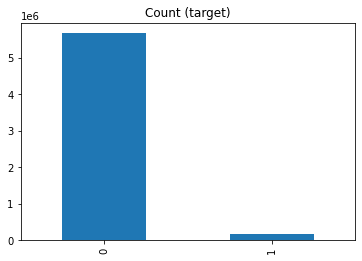

In [3]:
target_count = data.migrante_4.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [5]:
# Class count
count_class_0, count_class_1 = data.migrante_4.value_counts()

# Divide by class
df_class_0 = data[data['migrante_4'] == 0]
df_class_1 = data[data['migrante_4'] == 1]

# Random Undersampling

In [6]:
#Random Undersampling (RUS): It is a non-heuristic method that aims to
#balance class distribution through the random elimination of majority class
#examples to get a balanced instance set. The final ratio of balancing can be
#adjusted.

#For imbalance ratio 1:4
df_class_0_under_4 = df_class_0.sample((count_class_1*4))
#For imbalance ratio 1:2
df_class_0_under_2 = df_class_0.sample((count_class_1*2))
#For imbalance ratio 1:1
df_class_0_under_1 = df_class_0.sample(count_class_1)

#create df with the 3 balance ratios
df_test_under_4 = pd.concat([df_class_0_under_4, df_class_1], axis=0)
df_test_under_2 = pd.concat([df_class_0_under_2, df_class_1], axis=0)
df_test_under_1 = pd.concat([df_class_0_under_1, df_class_1], axis=0)

print('Random under-sampling for IR 1:4')
target_count_4 = df_test_under_4.migrante_4.value_counts()
print('Class 0:', target_count_4[0])
print('Class 1:', target_count_4[1])
print('Proportion:', round(target_count_4[0] / target_count_4[1], 2), ': 1')
print("--------------------------------------")
print('Random under-sampling for IR 1:2')
target_count_2 = df_test_under_2.migrante_4.value_counts()
print('Class 0:', target_count_2[0])
print('Class 1:', target_count_2[1])
print('Proportion:', round(target_count_2[0] / target_count_2[1], 2), ': 1')
print("--------------------------------------")
print('Random under-sampling for IR 1:1')
target_count_1 = df_test_under_1.migrante_4.value_counts()
print('Class 0:', target_count_1[0])
print('Class 1:', target_count_1[1])
print('Proportion:', round(target_count_1[0] / target_count_1[1], 2), ': 1')

Random under-sampling for IR 1:4
Class 0: 716332
Class 1: 179083
Proportion: 4.0 : 1
--------------------------------------
Random under-sampling for IR 1:2
Class 0: 358166
Class 1: 179083
Proportion: 2.0 : 1
--------------------------------------
Random under-sampling for IR 1:1
Class 0: 179083
Class 1: 179083
Proportion: 1.0 : 1


### Save new df´s

In [7]:
df_test_under_4.to_csv("BASE7_under_4.csv", index = False)
df_test_under_2.to_csv("BASE7_under_2.csv", index = False)
df_test_under_1.to_csv("BASE7_under_1.csv", index = False)

In [8]:
df_test_under_4.describe()

migrante     migrante_2     migrante_3  migrante_4         FACTOR  \
count  895415.000000  895415.000000  895415.000000    895415.0  895415.000000   
mean        0.000475       0.000333       0.005018         0.2       5.760973   
std         0.021781       0.018240       0.070658         0.4       8.695747   
min         0.000000       0.000000       0.000000         0.0       1.000000   
25%         0.000000       0.000000       0.000000         0.0       2.000000   
50%         0.000000       0.000000       0.000000         0.0       3.000000   
75%         0.000000       0.000000       0.000000         0.0       6.000000   
max         1.000000       1.000000       1.000000         1.0     400.000000   

                 ENT            MUN         CVEGEO       COCINA_1  \
count  895415.000000  895415.000000  895415.000000  895415.000000   
mean       17.857789      72.328194   17930.117041       0.849778   
std         7.995573      96.135116    8013.348654       0.357289   
min         1.000000       1.000000    1001.000000       0.000000   
25%        12.000000      15.000000   12050.000000       1.000000   
50%        17.000000      40.000000   17012.000000       1.000000   
75%        24.000000      90.000000   24021.000000       1.000000   
max        32.000000     570.000000   32058.000000       1.000000   

       COMBUSTIBLE_1  ELECTRICIDAD_5  ABA_AGUA_ENTU_1     AUTOPROP_7  \
count  895415.000000   895415.000000    895415.000000  895415.000000   
mean        0.309623        0.973447         0.753825       0.349785   
std         0.462338        0.160773         0.430782       0.476902   
min         0.000000        0.000000         0.000000       0.000000   
25%         0.000000        1.000000         1.000000       0.000000   
50%         0.000000        1.000000         1.000000       0.000000   
75%         1.000000        1.000000         1.000000       1.000000   
max         1.000000        1.000000         1.000000       1.000000   

           CELULAR_3     TENENCIA_1     TENENCIA_2        DEUDA_1  \
count  895415.000000  895415.000000  895415.000000  895415.000000   
mean        0.688453       0.696900       0.141045       0.032739   
std         0.463126       0.459598       0.348068       0.177953   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         1.000000       1.000000       0.000000       0.000000   
75%         1.000000       1.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

             DEUDA_2  INGR_PEROTROPAIS_1  INGR_PERDENTPAIS_3  INGR_AYUGOB_5  \
count  895415.000000       895415.000000       895415.000000  895415.000000   
mean        0.060118            0.067896            0.074806       0.387175   
std         0.237706            0.251567            0.263077       0.487104   
min         0.000000            0.000000            0.000000       0.000000   
25%         0.000000            0.000000            0.000000       0.000000   
50%         0.000000            0.000000            0.000000       0.000000   
75%         0.000000            0.000000            0.000000       1.000000   
max         1.000000            1.000000            1.000000       1.000000   

            INGTRMEN  TERRENO_AGROPE_1  TERRENO_VIVERO_3      CONACT_10  \
count  895415.000000     895415.000000     895415.000000  895415.000000   
mean        0.001536          0.161705          0.006030       1.257771   
std         0.003480          0.368180          0.077416       1.020735   
min         0.000000          0.000000          0.000000       0.000000   
25%         0.000000          0.000000          0.000000       1.000000   
50%         0.000964          0.000000          0.000000       1.000000   
75%         0.002000          0.000000          0.000000       2.000000   
max         0.750000          1.000000          1.000000      28.000000   

 

In [9]:
df_test_under_2.describe()

migrante     migrante_2     migrante_3     migrante_4  \
count  537249.000000  537249.000000  537249.000000  537249.000000   
mean        0.000698       0.000555       0.008363       0.333333   
std         0.026410       0.023545       0.091066       0.471405   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       1.000000   
max         1.000000       1.000000       1.000000       1.000000   

              FACTOR            ENT            MUN         CVEGEO  \
count  537249.000000  537249.000000  537249.000000  537249.000000   
mean        6.007967      17.869372      70.906818   17940.278376   
std         8.883103       8.007473      95.061155    8025.251572   
min         1.000000       1.000000       1.000000    1001.000000   
25%         2.000000      12.000000      15.000000   12054.000000   
50%         3.000000      17.000000      39.000000   17020.000000   
75%         6.000000      24.000000      88.000000   24021.000000   
max       322.000000      32.000000     570.000000   32058.000000   

            COCINA_1  COMBUSTIBLE_1  ELECTRICIDAD_5  ABA_AGUA_ENTU_1  \
count  537249.000000  537249.000000   537249.000000    537249.000000   
mean        0.847897       0.289112        0.974717         0.760681   
std         0.359121       0.453350        0.156982         0.426668   
min         0.000000       0.000000        0.000000         0.000000   
25%         1.000000       0.000000        1.000000         1.000000   
50%         1.000000       0.000000        1.000000         1.000000   
75%         1.000000       1.000000        1.000000         1.000000   
max         1.000000       1.000000        1.000000         1.000000   

          AUTOPROP_7      CELULAR_3     TENENCIA_1     TENENCIA_2  \
count  537249.000000  537249.000000  537249.000000  537249.000000   
mean        0.355280       0.714075       0.661481       0.172816   
std         0.478599       0.451854       0.473206       0.378088   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       1.000000       1.000000       0.000000   
75%         1.000000       1.000000       1.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

             DEUDA_1        DEUDA_2  INGR_PEROTROPAIS_1  INGR_PERDENTPAIS_3  \
count  537249.000000  537249.000000       537249.000000       537249.000000   
mean        0.031801       0.065257            0.065953            0.080063   
std         0.175470       0.246978            0.248200            0.271392   
min         0.000000       0.000000            0.000000            0.000000   
25%         0.000000       0.000000            0.000000            0.000000   
50%         0.000000       0.000000            0.000000            0.000000   
75%         0.000000       0.000000            0.000000            0.000000   
max         1.000000       1.000000            1.000000            1.000000   

       INGR_AYUGOB_5       INGTRMEN  TERRENO_AGROPE_1  TERRENO_VIVERO_3  \
count  537249.000000  537249.000000     537249.000000     537249.000000   
mean        0.358912       0.001664          0.150762          0.005889   
std         0.479682       0.003778          0.357818          0.076515   
min         0.000000       0.000000          0.000000          0.000000   
25%         0.000000       0.000000          0.000000          0.000000   
50%         0.000000       0.001000          0.000000          0.000000   
75%         1.000000       0.002143          0.000000          0.000000   
max         1.000000       0.750000          1.000000          1.000000   

           CONACT_10      CONACT_13      CONACT_31        NUMPERS  \
count  537249.000000  537249.000000  537

In [10]:
df_test_under_1.describe()

migrante     migrante_2     migrante_3     migrante_4  \
count  358166.000000  358166.000000  358166.000000  358166.000000   
mean        0.000963       0.000832       0.012544       0.500000   
std         0.031021       0.028833       0.111298       0.500001   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.500000   
75%         0.000000       0.000000       0.000000       1.000000   
max         1.000000       1.000000       1.000000       1.000000   

              FACTOR            ENT            MUN         CVEGEO  \
count  358166.000000  358166.000000  358166.000000  358166.000000   
mean        6.306377      17.870903      69.231454   17940.134890   
std         9.230122       8.030470      94.253417    8048.235036   
min         1.000000       1.000000       1.000000    1001.000000   
25%         2.000000      12.000000      14.000000   12061.000000   
50%         3.000000      17.000000      38.000000   17026.000000   
75%         7.000000      24.000000      85.000000   24021.000000   
max       400.000000      32.000000     570.000000   32058.000000   

            COCINA_1  COMBUSTIBLE_1  ELECTRICIDAD_5  ABA_AGUA_ENTU_1  \
count  358166.000000  358166.000000   358166.000000    358166.000000   
mean        0.846323       0.262621        0.976447         0.771282   
std         0.360640       0.440059        0.151653         0.420008   
min         0.000000       0.000000        0.000000         0.000000   
25%         1.000000       0.000000        1.000000         1.000000   
50%         1.000000       0.000000        1.000000         1.000000   
75%         1.000000       1.000000        1.000000         1.000000   
max         1.000000       1.000000        1.000000         1.000000   

          AUTOPROP_7      CELULAR_3     TENENCIA_1     TENENCIA_2  \
count  358166.000000  358166.000000  358166.000000  358166.000000   
mean        0.362530       0.743315       0.617172       0.211938   
std         0.480731       0.436805       0.486078       0.408682   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       1.000000       1.000000       0.000000   
75%         1.000000       1.000000       1.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

             DEUDA_1        DEUDA_2  INGR_PEROTROPAIS_1  INGR_PERDENTPAIS_3  \
count  358166.000000  358166.000000       358166.000000       358166.000000   
mean        0.030829       0.071579            0.064305            0.087800   
std         0.172855       0.257789            0.245296            0.283004   
min         0.000000       0.000000            0.000000            0.000000   
25%         0.000000       0.000000            0.000000            0.000000   
50%         0.000000       0.000000            0.000000            0.000000   
75%         0.000000       0.000000            0.000000            0.000000   
max         1.000000       1.000000            1.000000            1.000000   

       INGR_AYUGOB_5       INGTRMEN  TERRENO_AGROPE_1  TERRENO_VIVERO_3  \
count  358166.000000  358166.000000     358166.000000     358166.000000   
mean        0.322390       0.001818          0.137138          0.005643   
std         0.467392       0.003738          0.343993          0.074905   
min         0.000000       0.000000          0.000000          0.000000   
25%         0.000000       0.000000          0.000000          0.000000   
50%         0.000000       0.001072          0.000000          0.000000   
75%         1.000000       0.002250          0.000000          0.000000   
max         1.000000       0.500009          1.000000          1.000000   

           CONACT_10      CONACT_13      CONACT_31        NUMPERS  \
count  358166.000000  358166.000000  358

# Create statistics for BASE/_under_4 for stata models 20/01/2021

In [3]:
os.chdir("C:\\Users\\juanm\\Documents\\Python\\cc migration model\\CC&MIGRATION")
pd.set_option('display.max_columns', None)

data = pd.read_csv("BASE7_under_4.csv")

In [4]:
# in order to get only the info from the four municipalities to check for conditional probabilities:
fourmun = data[data["CVEGEO"].isin([7019, 7041, 7052, 7099])]

In [5]:
fourmun.head()

migrante  migrante_2  migrante_3  migrante_4  FACTOR  ENT  MUN  CVEGEO  \
512         0           0           0           0      22    7   19    7019   
573         0           0           0           0       4    7   99    7099   
652         0           0           0           0       4    7   99    7099   
697         0           0           0           0       5    7   99    7099   
783         0           0           0           0       4    7   99    7099   

     COCINA_1  COMBUSTIBLE_1  ELECTRICIDAD_5  ABA_AGUA_ENTU_1  AUTOPROP_7  \
512         1              0               1                1           0   
573         1              1               1                1           1   
652         1              0               1                1           1   
697         1              1               1                0           1   
783         1              1               1                1           0   

     CELULAR_3  TENENCIA_1  TENENCIA_2  DEUDA_1  DEUDA_2  INGR_PEROTROPAIS_1  \
512          1           1           0        0        0                   1   
573          1           1           0        0        0                   0   
652          1           1           0        0        0                   0   
697          0           1           0        0        0                   0   
783          0           1           0        0        0                   0   

     INGR_PERDENTPAIS_3  INGR_AYUGOB_5  INGTRMEN  TERRENO_AGROPE_1  \
512                   0              1  0.000643                 0   
573                   0              1  0.000000                 1   
652                   0              0  0.001393                 0   
697                   0              0  0.000000                 0   
783                   0              1  0.000167                 1   

     TERRENO_VIVERO_3  CONACT_10  CONACT_13  CONACT_31  NUMPERS  INSAN  \
512                 0          1          0          2        4      0   
573                 0          1          0          2        5      1   
652                 0          1          0          1        4      1   
697                 0          1          0          0        2      1   
783                 0          1          0          0        4      0   

     NIVACAD_0_J  NIVACAD_1_J  ALFABET_5_J  SERSALUD_NO  JEFE_MUJ_CASADA  \
512            0            0            1            0                1   
573            1            0            0            0                0   
652            0            0            1            0                0   
697            0            0            1            0                0   
783            0            0            1            0                0   

     EDAD_0_5  EDAD_15_29  EDAD_30_59  EDAD_6_14  EDAD_60  EDUCLESSPRIM_2010  \
512         0           1           1          2        0             0.4062   
573         0           1           2          2        2             0.6022   
652         1           1           2          0        0             0.6022   
697         0           0           2          0        0             0.6022   
783         1           1           2          0        0             0.6022   

     LABORAGRIC  URBANIZ_2010  UNEMPLOY_2010  PIPEDWATER_2010  \
512      0.1509        0.6917         0.0691           0.8638   
573      0.7868        0.2641         0.0139           0.7994   
652      0.7868        0.2641         0.0139           0.7994   
697      0.7868        0.2641         0.0139           0.7994   
783      0.7868        0.2641         0.0139           0.7994   

     ELECTRICITY_2010  TEMPSEASON  ANAVGTEMP  MXTMPWRMMO  TEMPANRG  \
512            0.9716      0.0832     0.3747      0.3289    0.2226   
573            0.9437      0.0951     0.6024      0.5610    0.2432   
652            0.9437      0.0951     0.6024      0.5610    0.2432   
697            0.9437      0.0951     0.6024      0.5610    0.2432   
783            0.9437      0.0951     0.6

In [6]:
fourmun.CVEGEO.value_counts()

7099    820
7019    619
7041    580
7052    571
Name: CVEGEO, dtype: int64

In [7]:
fourmun.describe()

migrante  migrante_2  migrante_3   migrante_4       FACTOR     ENT  \
count  2590.000000      2590.0      2590.0  2590.000000  2590.000000  2590.0   
mean      0.011583         0.0         0.0     0.071429     5.035135     7.0   
std       0.107020         0.0         0.0     0.257589     4.111605     0.0   
min       0.000000         0.0         0.0     0.000000     1.000000     7.0   
25%       0.000000         0.0         0.0     0.000000     3.000000     7.0   
50%       0.000000         0.0         0.0     0.000000     4.000000     7.0   
75%       0.000000         0.0         0.0     0.000000     6.000000     7.0   
max       1.000000         0.0         0.0     1.000000    31.000000     7.0   

               MUN       CVEGEO     COCINA_1  COMBUSTIBLE_1  ELECTRICIDAD_5  \
count  2590.000000  2590.000000  2590.000000    2590.000000     2590.000000   
mean     56.530116  7056.530116     0.942471       0.744015        0.966023   
std      31.090016    31.090016     0.232896       0.436497        0.181205   
min      19.000000  7019.000000     0.000000       0.000000        0.000000   
25%      41.000000  7041.000000     1.000000       0.000000        1.000000   
50%      52.000000  7052.000000     1.000000       1.000000        1.000000   
75%      99.000000  7099.000000     1.000000       1.000000        1.000000   
max      99.000000  7099.000000     1.000000       1.000000        1.000000   

       ABA_AGUA_ENTU_1   AUTOPROP_7    CELULAR_3   TENENCIA_1   TENENCIA_2  \
count      2590.000000  2590.000000  2590.000000  2590.000000  2590.000000   
mean          0.586100     0.219305     0.491506     0.871042     0.058301   
std           0.492626     0.413856     0.500024     0.335218     0.234357   
min           0.000000     0.000000     0.000000     0.000000     0.000000   
25%           0.000000     0.000000     0.000000     1.000000     0.000000   
50%           1.000000     0.000000     0.000000     1.000000     0.000000   
75%           1.000000     0.000000     1.000000     1.000000     0.000000   
max           1.000000     1.000000     1.000000     1.000000     1.000000   

           DEUDA_1      DEUDA_2  INGR_PEROTROPAIS_1  INGR_PERDENTPAIS_3  \
count  2590.000000  2590.000000         2590.000000         2590.000000   
mean      0.017761     0.010425            0.025483            0.045174   
std       0.132106     0.101588            0.157616            0.207725   
min       0.000000     0.000000            0.000000            0.000000   
25%       0.000000     0.000000            0.000000            0.000000   
50%       0.000000     0.000000            0.000000            0.000000   
75%       0.000000     0.000000            0.000000            0.000000   
max       1.000000     1.000000            1.000000            1.000000   

       INGR_AYUGOB_5     INGTRMEN  TERRENO_AGROPE_1  TERRENO_VIVERO_3  \
count    2590.000000  2590.000000       2590.000000       2590.000000   
mean        0.689575     0.000580          0.388417          0.012741   
std         0.462757     0.001225          0.487484          0.112178   
min         0.000000     0.000000          0.000000          0.000000   
25%         0.000000     0.000000          0.000000          0.000000   
50%         1.000000     0.000000          0.000000          0.000000   
75%         1.000000     0.000750          1.000000          0.000000   
max         1.000000     0.020250          1.000000          1.000000   

         CONACT_10    CONACT_13    CONACT_31      NUMPERS        INSAN  \
count  2590.000000  2590.000000  2590.000000  2590.000000  2590.000000   
mean      1.111969     0.127413     0.432819     3.841313     0.734749   
std       0.910759     0.436794     0.728976     1.219416     0.992590   
min       0.000000     0.000000     0.000000     1.000000     0.000000   
25%       1.000000     0.000000     0.000000     3.000000     0.000000   
50%       1.000000     0.000000     0.000000     4.000000     0.000000   
75%       2.000000    

In [8]:
data = pd.DataFrame(fourmun.describe()) 
datat = data.T
datat = datat[["mean", "std", "min", "max"]]


In [11]:
print(datat.round(decimals = 4))

                         mean      std        min        max
migrante               0.0116   0.1070     0.0000     1.0000
migrante_2             0.0000   0.0000     0.0000     0.0000
migrante_3             0.0000   0.0000     0.0000     0.0000
migrante_4             0.0714   0.2576     0.0000     1.0000
FACTOR                 5.0351   4.1116     1.0000    31.0000
ENT                    7.0000   0.0000     7.0000     7.0000
MUN                   56.5301  31.0900    19.0000    99.0000
CVEGEO              7056.5301  31.0900  7019.0000  7099.0000
COCINA_1               0.9425   0.2329     0.0000     1.0000
COMBUSTIBLE_1          0.7440   0.4365     0.0000     1.0000
ELECTRICIDAD_5         0.9660   0.1812     0.0000     1.0000
ABA_AGUA_ENTU_1        0.5861   0.4926     0.0000     1.0000
AUTOPROP_7             0.2193   0.4139     0.0000     1.0000
CELULAR_3              0.4915   0.5000     0.0000     1.0000
TENENCIA_1             0.8710   0.3352     0.0000     1.0000
TENENCIA_2             0

# Create statistics for BASE7 for stata models 21/01/2021

In [2]:
os.chdir("C:\\Users\\juanm\\Documents\\Python\\cc migration model\\CC&MIGRATION")
pd.set_option('display.max_columns', None)
data = pd.read_csv("BASE7.csv")

# in order to get only the info from the four municipalities to check for conditional probabilities:
fourmun = data[data["CVEGEO"].isin([7019, 7041, 7052, 7099])]

data = pd.DataFrame(fourmun.describe()) 
datat = data.T
print(datat.round(decimals = 4))

                      count       mean      std        min        25%  \
migrante            18829.0     0.0117   0.1077     0.0000     0.0000   
migrante_2          18829.0     0.0000   0.0000     0.0000     0.0000   
migrante_3          18829.0     0.0000   0.0000     0.0000     0.0000   
migrante_4          18829.0     0.0098   0.0986     0.0000     0.0000   
FACTOR              18829.0     4.9567   4.2029     1.0000     2.0000   
ENT                 18829.0     7.0000   0.0000     7.0000     7.0000   
MUN                 18829.0    57.3745  31.2979    19.0000    41.0000   
CVEGEO              18829.0  7057.3745  31.2979  7019.0000  7041.0000   
COCINA_1            18829.0     0.9433   0.2312     0.0000     1.0000   
COMBUSTIBLE_1       18829.0     0.7587   0.4279     0.0000     1.0000   
ELECTRICIDAD_5      18829.0     0.9688   0.1738     0.0000     1.0000   
ABA_AGUA_ENTU_1     18829.0     0.5877   0.4923     0.0000     0.0000   
AUTOPROP_7          18829.0     0.2211   0.4150    

# Create statistics from BASE7 for migrantes_4 21/01/2021

In [3]:
os.chdir("C:\\Users\\juanm\\Documents\\Python\\cc migration model\\CC&MIGRATION")
pd.set_option('display.max_columns', None)
data = pd.read_csv("BASE7.csv")

# in order to get only the info from the four municipalities to check for conditional probabilities:
fourmun = data[data["migrante_4"].isin([1])]

data = pd.DataFrame(fourmun.describe()) 
datat = data.T
print(datat.round(decimals = 4))

                       count        mean        std        min         25%  \
migrante            179083.0      0.0018     0.0422     0.0000      0.0000   
migrante_2          179083.0      0.0017     0.0408     0.0000      0.0000   
migrante_3          179083.0      0.0251     0.1564     0.0000      0.0000   
migrante_4          179083.0      1.0000     0.0000     1.0000      1.0000   
FACTOR              179083.0      7.2149    10.0136     1.0000      2.0000   
ENT                 179083.0     17.9444     8.0808     1.0000     13.0000   
MUN                 179083.0     64.0710    90.2074     1.0000     12.0000   
CVEGEO              179083.0  18008.4264  8098.5568  1001.0000  13013.0000   
COCINA_1            179083.0      0.8401     0.3665     0.0000      1.0000   
COMBUSTIBLE_1       179083.0      0.1854     0.3886     0.0000      0.0000   
ELECTRICIDAD_5      179083.0      0.9809     0.1369     0.0000      1.0000   
ABA_AGUA_ENTU_1     179083.0      0.7975     0.4019     0.0000  

# Create statistics from BASE7 for people from Chiapas 21/01/2021

In [4]:
os.chdir("C:\\Users\\juanm\\Documents\\Python\\cc migration model\\CC&MIGRATION")
pd.set_option('display.max_columns', None)
data = pd.read_csv("BASE7.csv")

# in order to get only the info from the four municipalities to check for conditional probabilities:
fourmun = data[data["ENT"].isin([7])]

data = pd.DataFrame(fourmun.describe()) 
datat = data.T
print(datat.round(decimals = 4))

                       count       mean      std        min        25%  \
migrante            406797.0     0.0023   0.0476     0.0000     0.0000   
migrante_2          406797.0     0.0000   0.0000     0.0000     0.0000   
migrante_3          406797.0     0.0000   0.0000     0.0000     0.0000   
migrante_4          406797.0     0.0129   0.1126     0.0000     0.0000   
FACTOR              406797.0     3.0458   3.8630     1.0000     1.0000   
ENT                 406797.0     7.0000   0.0000     7.0000     7.0000   
MUN                 406797.0    60.4493  34.5739     1.0000    30.0000   
CVEGEO              406797.0  7060.4493  34.5739  7001.0000  7030.0000   
COCINA_1            406797.0     0.7902   0.4072     0.0000     1.0000   
COMBUSTIBLE_1       406797.0     0.7024   0.4572     0.0000     0.0000   
ELECTRICIDAD_5      406797.0     0.9676   0.1770     0.0000     1.0000   
ABA_AGUA_ENTU_1     406797.0     0.6158   0.4864     0.0000     0.0000   
AUTOPROP_7          406797.0     0.126